In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# load data


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# import eli5 # Feature importance evaluation
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/527/hotel_bookings.csv') #for Leting Sun
df = pd.read_csv('/content/drive/MyDrive/hotel_bookings.csv') # For Ken

In [ ]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# getting data information

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# data cleaning


In [ ]:
nullArray = df.isnull().sum()
nullArray = nullArray[nullArray > 0]
print(nullArray)

children         4
country        488
agent        16340
company     112593
dtype: int64


In [ ]:
df_null = df.isnull().sum()/len(df)*100
df_null = df_null[df_null>0]
df_null

children     0.003350
country      0.408744
agent       13.686238
company     94.306893
dtype: float64

In [ ]:
#filling children,since most booking has zero children ,so we fill children as 0
print(df['children'].value_counts())
df['children'].fillna(0, inplace=True)

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64


In [ ]:
#df['country'].value_counts() since there are 177 different country values, it is not ideal to assgin null to any one of them
df['country'].fillna('unknown', inplace=True)

In [ ]:
print("the null rate of company roll is ",1-df['company'].count()/df['company'].size,'so we decide to delete this category')
df.drop('company', axis=1, inplace=True)

the null rate of company roll is  0.943068933746545 so we decide to delete this category


In [ ]:
#probably booking with people themselves，so replace null with new category 0X
df['agent'].fillna(0.0, inplace=True)

In [ ]:
#data description says sc = undefined
df["meal"].replace("Undefined", "SC", inplace=True)

In [ ]:
noAdults = df.loc[df["adults"]==0].index
df.drop(df.index[noAdults], inplace=True)

In [ ]:
# There is no null value now
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

In [ ]:
df.shape

(118987, 31)

In [ ]:
# Original DataFrame has 119390 entries. We eliminated 403 rows.

In [ ]:
119390 - 118987

403

In [ ]:
# Remove duplicate entries

df.duplicated().sum()

31983

In [ ]:
df[df.duplicated()].head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,0,Transient,98.00,0,1,Check-Out,2015-07-03
22,Resort Hotel,0,72,2015,July,27,1,2,4,2,...,1,No Deposit,250.0,0,Transient,84.67,0,1,Check-Out,2015-07-07
43,Resort Hotel,0,70,2015,July,27,2,2,3,2,...,0,No Deposit,250.0,0,Transient,137.00,0,1,Check-Out,2015-07-07
138,Resort Hotel,1,5,2015,July,28,5,1,0,2,...,0,No Deposit,240.0,0,Transient,97.00,0,0,Canceled,2015-07-01
200,Resort Hotel,0,0,2015,July,28,7,0,1,1,...,0,No Deposit,240.0,0,Transient,109.80,0,3,Check-Out,2015-07-08


Check the types of variables in our dataset


In [ ]:
Categorical_Var_list = []
for i in df.columns:
  if df[i].dtypes == 'object':
    Categorical_Var_list.append(i)
print(Categorical_Var_list) 
len(Categorical_Var_list)

['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date']


12

### Note that 'agent' is also a categorical variable. But it is already encoded since this column is the ID of the agent

**There are 12 categorical variables**

In [ ]:
# Check the value in these 12 categorical variables
for i in Categorical_Var_list:
  print(i)
  print(df[i].value_counts())
  print('-----------------------')


hotel
City Hotel      78940
Resort Hotel    40047
Name: hotel, dtype: int64
-----------------------
arrival_date_month
August       13829
July         12611
May          11764
October      11131
April        11057
June         10917
September    10489
March         9751
February      8034
November      6765
December      6736
January       5903
Name: arrival_date_month, dtype: int64
-----------------------
meal
BB    92020
HB    14454
SC    11715
FB      798
Name: meal, dtype: int64
-----------------------
country
PRT    48440
GBR    12105
FRA    10376
ESP     8546
DEU     7271
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: country, Length: 178, dtype: int64
-----------------------
market_segment
Online TA        56221
Offline TA/TO    24179
Groups           19791
Direct           12553
Corporate         5282
Complementary      724
Aviation           235
Undefined            2
Name: market_segment, dtype: int64
-----------------------
distribution_c

**All these 12 categorical variables are not ordinal except reservation_status_date**

# decriptive analysis


In [ ]:
#we want to know the information of the guest that actually visited
visited = df.loc[df['is_canceled'] == 0]
visited.shape

(74872, 31)

In [ ]:
visited.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

Overall Cancellation

<Axes: xlabel='is_canceled', ylabel='count'>

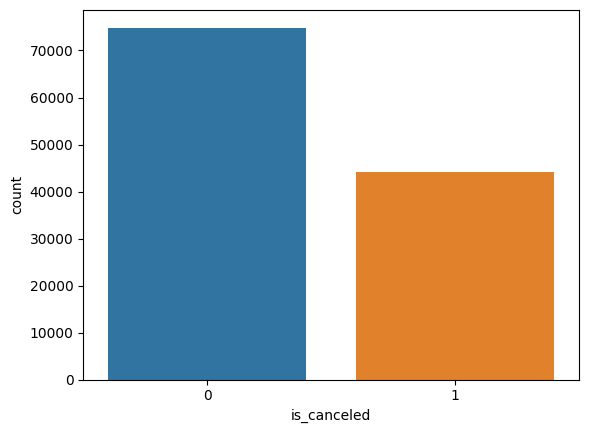

In [ ]:
sns.countplot( x = 'is_canceled', data = df)

Cancellation Groupby hotel Type

<Axes: xlabel='hotel', ylabel='count'>

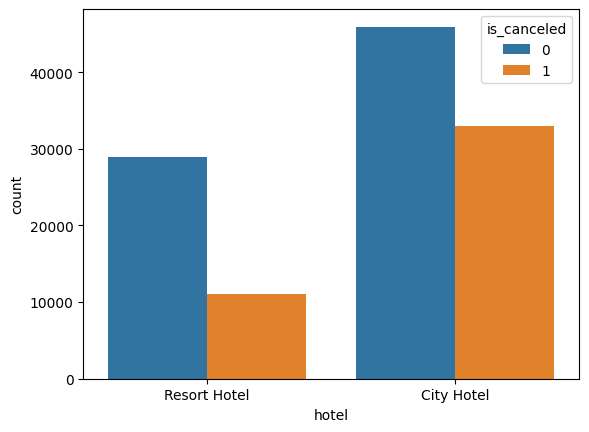

In [ ]:
sns.countplot(x = 'hotel',hue = 'is_canceled', data = df)

In [ ]:
df.groupby('hotel')['is_canceled'].value_counts()

hotel         is_canceled
City Hotel    0              45945
              1              32995
Resort Hotel  0              28927
              1              11120
Name: is_canceled, dtype: int64

City Hotel has higher proportion of cancellation

Question 1: what is the top overall travel season?

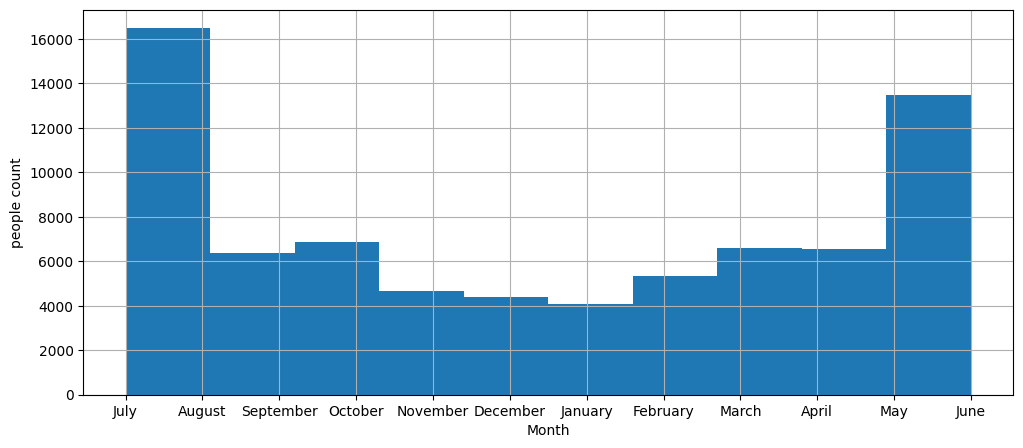

In [ ]:
fig = plt.figure(figsize=(12, 5))
visited['arrival_date_month'].hist()
plt.xlabel('Month')
plt.ylabel('people count')
plt.show()

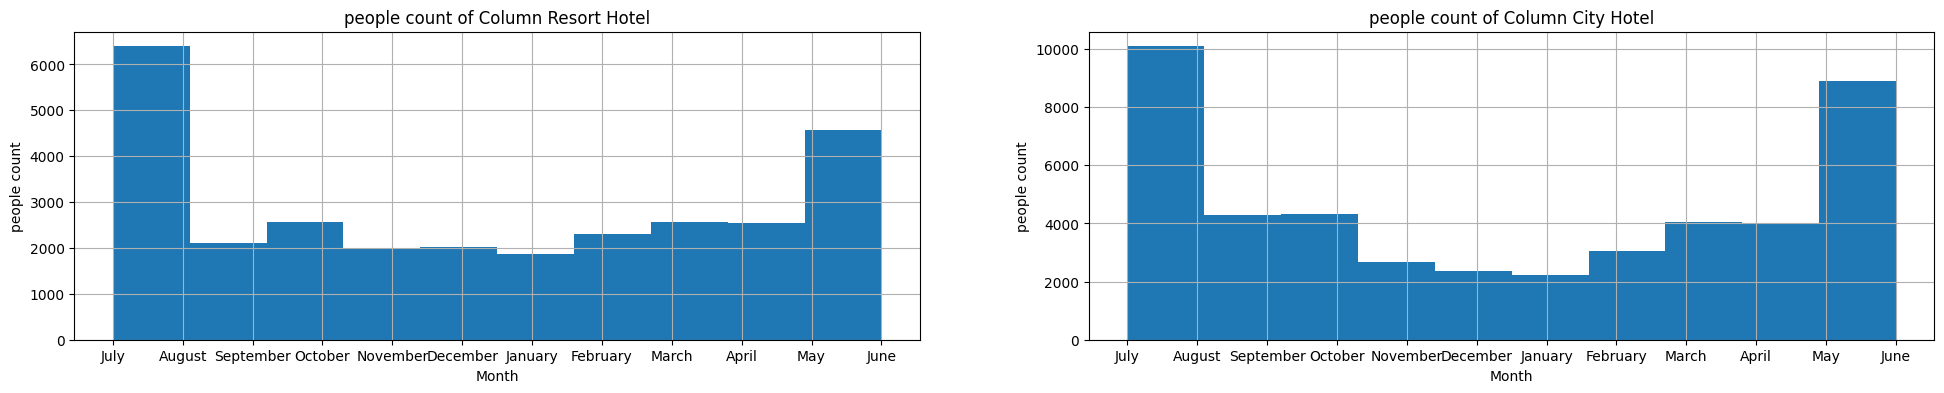

In [ ]:
hotel_type = visited['hotel'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(hotel_type), figsize=(24, 4))
for i,value in enumerate(hotel_type):
  visited.loc[visited['hotel'] == value]['arrival_date_month'].hist(ax=axes[i])
  axes[i].set_title('people count of Column {}'.format(value))
  axes[i].set_xlabel('Month')
  axes[i].set_ylabel('people count')

what kind of the hotel does people with most likely to go?


In [ ]:
df['hotel'].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [ ]:
visited['hotel'].value_counts()

City Hotel      45945
Resort Hotel    28927
Name: hotel, dtype: int64

<Axes: xlabel='hotel', ylabel='count'>

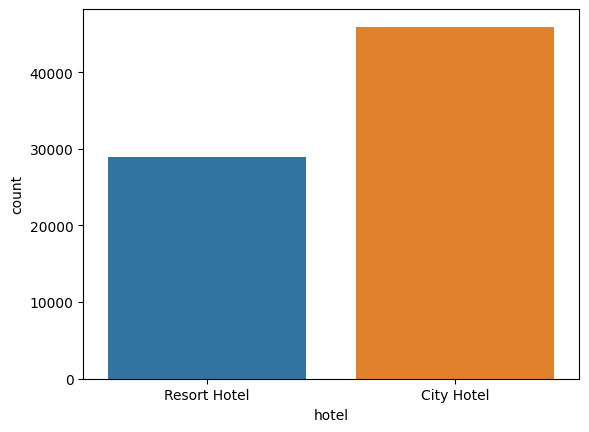

In [ ]:
sns.countplot( x = 'hotel', data = visited)

what kind of the hotel does people with children most likely to go?

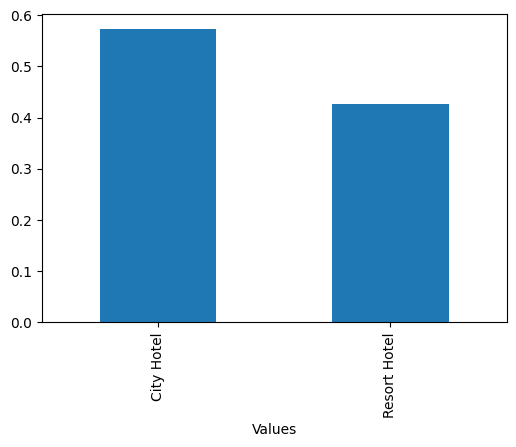

In [ ]:
withBaby = visited.loc[visited['children']+ visited['babies'] >0]
fig = plt.figure(figsize=(6, 4))
hotelPreferRate = withBaby['hotel'].value_counts(normalize = True)
ax = hotelPreferRate.plot(kind = 'bar')
ax.set_xlabel('Values', rotation=0)
plt.show()

should hotel prepare more children stuff in specific month?

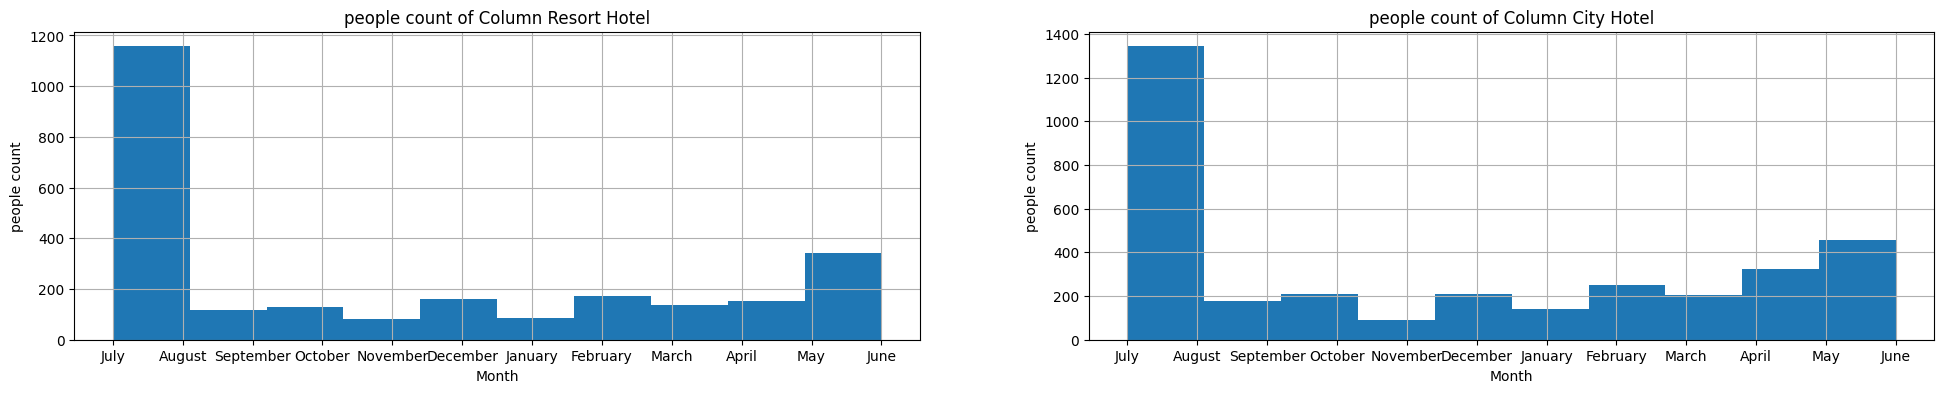

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(hotel_type), figsize=(24, 4))
for i,value in enumerate(withBaby['hotel'].unique()):
  withBaby.loc[withBaby['hotel'] == value]['arrival_date_month'].hist(ax=axes[i])
  axes[i].set_title('people count of Column {}'.format(value))
  axes[i].set_xlabel('Month')
  axes[i].set_ylabel('people count')

does specific year affect which month people want to travel?

In [ ]:
from pandas.core.base import value_counts
fig = plt.figure(figsize=(12, 5))
visited.groupby('arrival_date_year')['arrival_date_month'].value_counts()

arrival_date_year  arrival_date_month
2015               October               3218
                   September             3016
                   August                2281
                   December              1935
                   November              1851
                   July                  1515
2016               October               3669
                   May                   3554
                   September             3365
                   April                 3359
                   March                 3337
                   August                3214
                   June                  3188
                   July                  3053
                   November              2799
                   February              2539
                   December              2442
                   January               1683
2017               May                   3541
                   July                  3316
                   March                 3

<Figure size 1200x500 with 0 Axes>

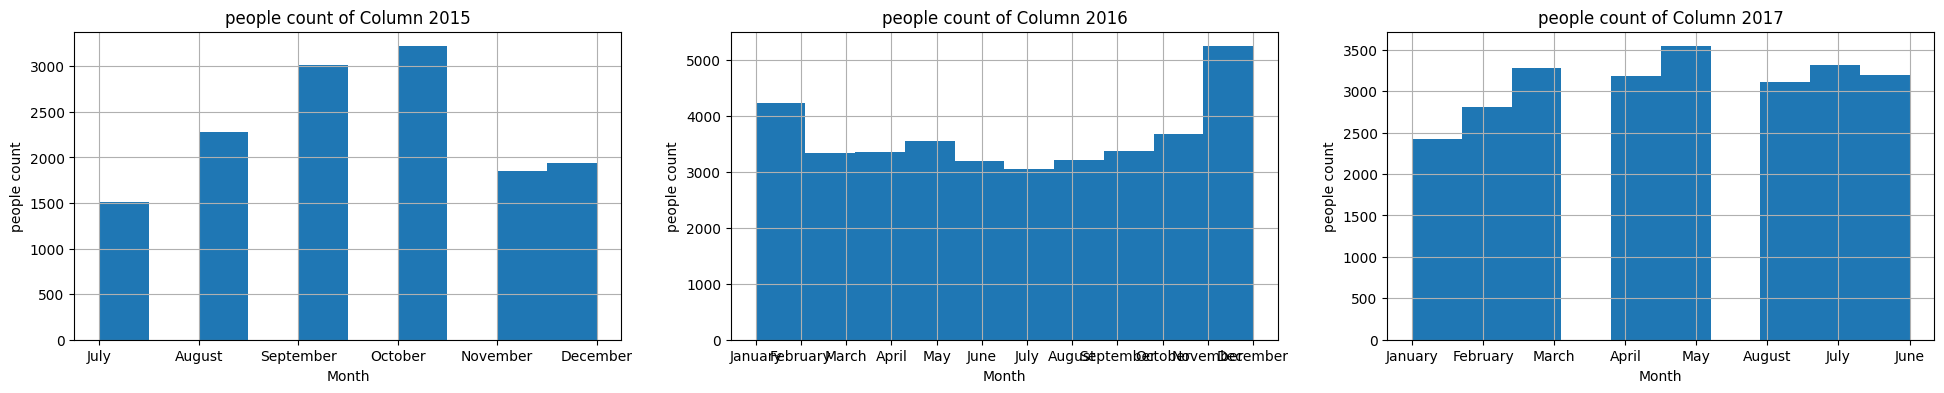

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 4))
for i,value in enumerate(visited['arrival_date_year'].unique()):
  visited.loc[visited['arrival_date_year'] == value]['arrival_date_month'].hist(ax=axes[i])
  axes[i].set_title('people count of Column {}'.format(value))
  axes[i].set_xlabel('Month')
  axes[i].set_ylabel('people count')

does people prefer to arrive at particular day?

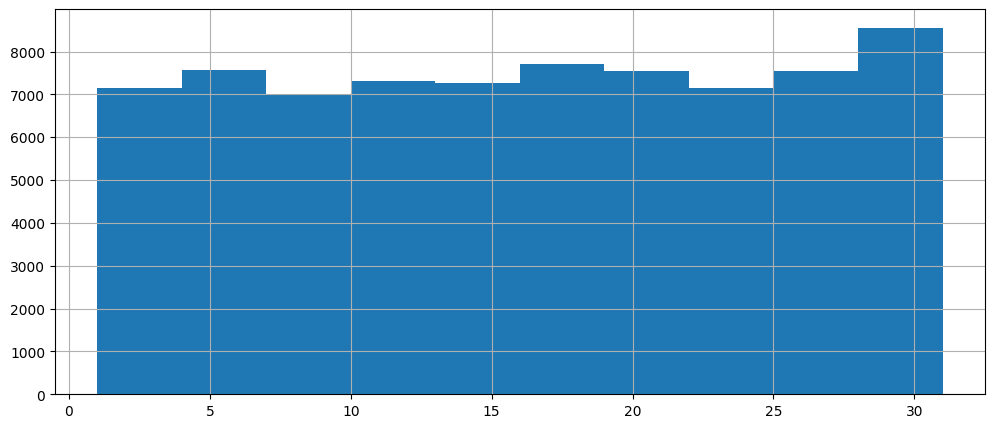

In [ ]:
fig = plt.figure(figsize=(12, 5))
visited['arrival_date_day_of_month'].hist()
# plt.xlabel('Month')
# plt.ylabel('people count')
plt.show()

which country is more porpular? 

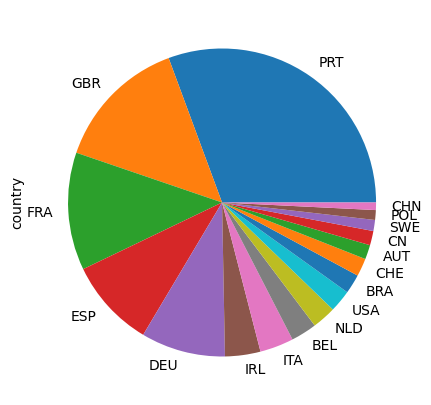

In [ ]:
s = visited['country'].value_counts()>500
idx = s[s.array == True].index
porpularCountries = visited[visited['country'].isin(idx)]['country'].value_counts()
# print(porpularCountries)
fig = plt.figure(figsize=(12, 5))
ax = porpularCountries.plot(kind = 'pie')
plt.show()

what month does people typicaly come in

<function matplotlib.pyplot.show(close=None, block=None)>

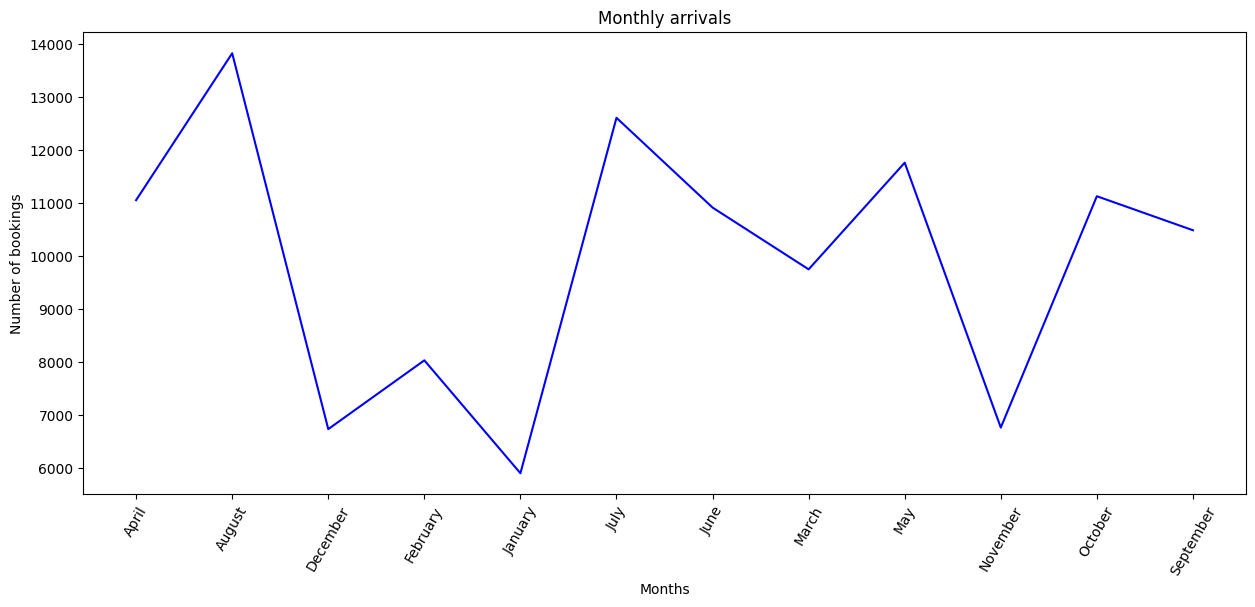

In [ ]:
df_year = df.groupby(['arrival_date_month']).agg({'hotel':'count'}).reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(x = "arrival_date_month",y = 'hotel', data = df_year, color = 'blue' )
plt.xticks(rotation = 60)
plt.title('Monthly arrivals', )
plt.xlabel('Months')
plt.ylabel('Number of bookings')
plt.show

See the Length of Stay

In [ ]:
df['total_stayNights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

Text(0, 0.5, 'No. of Bookings')

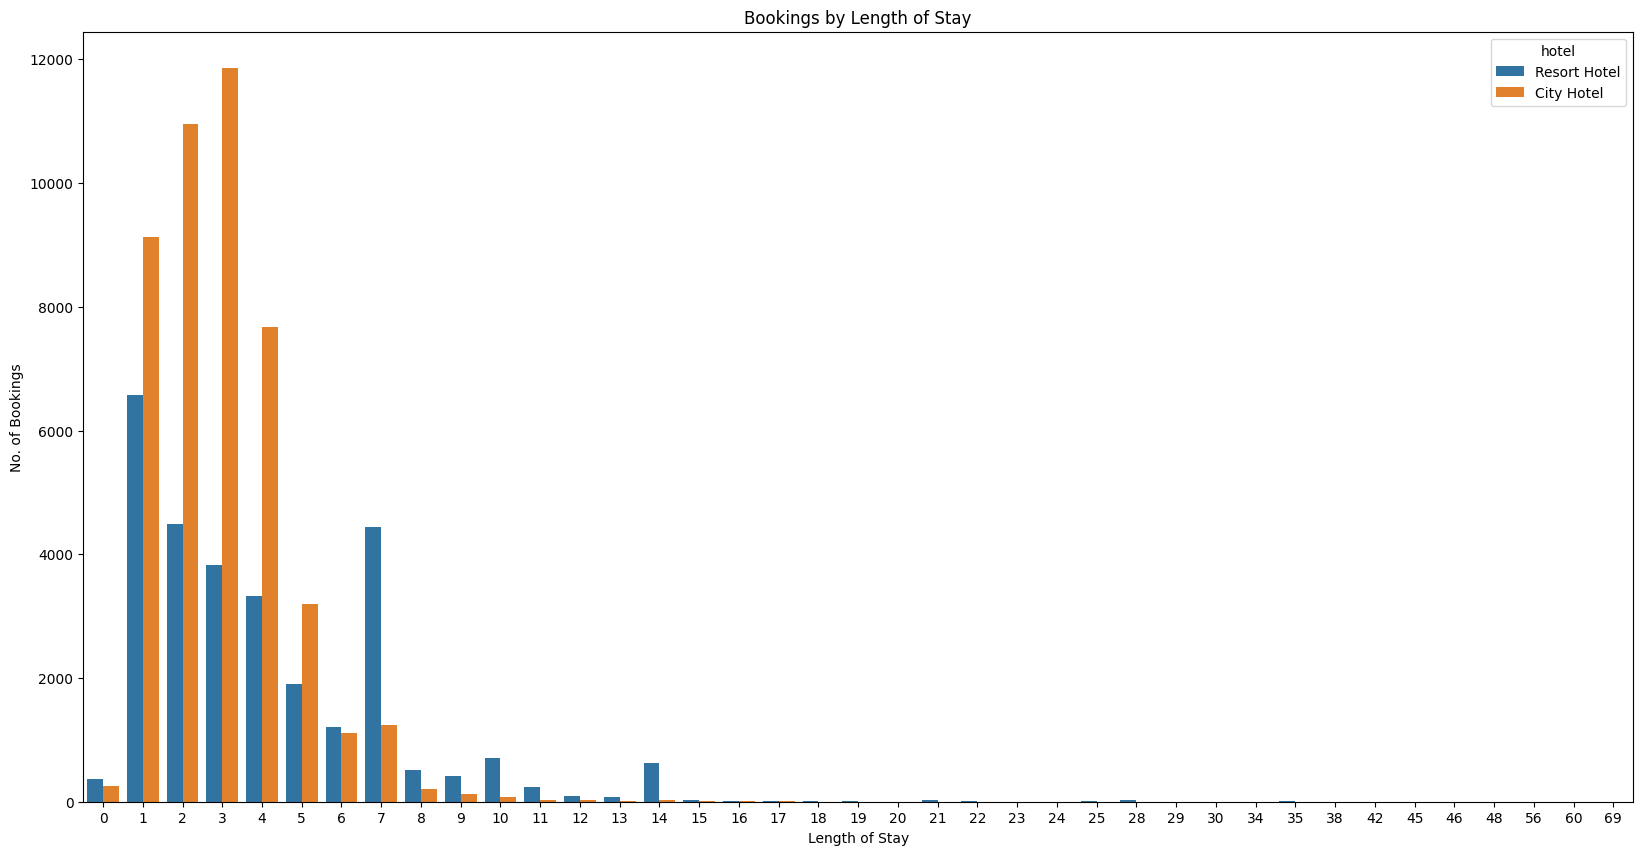

In [ ]:
fig = plt.figure(figsize = (20,10))
sns.countplot(x = 'total_stayNights', data = df.loc[df['is_canceled'] == 0], hue = 'hotel')
plt.title('Bookings by Length of Stay')
plt.xlabel('Length of Stay')
plt.ylabel('No. of Bookings')

## **Outlier Detection**

To preserve the dataset, we create a copy for our original dataset 'df' as 'df1

In [ ]:
df1 = df.copy()
df1.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_stayNights
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2


Combine Children and Babies into a new feature called 'Youngster' 

In [ ]:
df1['Youngster'] = df1['children'] + df1['babies']

In [ ]:
# Drop these 4 features since they are already combined into 2 features
df1 = df1.drop(['children', 'babies', 'stays_in_weekend_nights','stays_in_week_nights'], axis=1)

In [ ]:
df1.shape

(118987, 29)

In [ ]:
# First we need to find out which features are numeric

In [ ]:
numeric_Var_list = []
for i in df1.columns:
  if df1[i].dtypes == 'int64' or df1[i].dtypes == 'float64':
    numeric_Var_list.append(i)
print(numeric_Var_list) 
len(numeric_Var_list)

['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'adults', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'total_stayNights', 'Youngster']


17

We need to remove **'is_canceled' **the target variable,  and **'agent'** which was already deleted in previous steps


In [ ]:
numeric_Var_list.remove('is_canceled')
numeric_Var_list.remove('agent')

In [ ]:
df1 = df1.drop(['agent'], axis=1)

In [ ]:
len(numeric_Var_list) # Now we have 15 variables as numeric features, and we need to detect each of its outliers

15

In [ ]:
numeric_Var_list

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'adults',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_stayNights',
 'Youngster']

We examine each one of the numeric feature before we decide to apply any method to detect outliers. We will use box plot and histogram to examine these features. Features we could ignore includes 'arrival_date_year',
 'arrival_date_week_number' and 'arrival_date_day_of_month' as they are all valid input

In [ ]:
numeric_Var_list_Outliers = numeric_Var_list
numeric_Var_list_Outliers.remove('arrival_date_year')
numeric_Var_list_Outliers.remove('arrival_date_week_number')
numeric_Var_list_Outliers.remove('arrival_date_day_of_month')

In [ ]:
# We need to remove "is_repeated_guest" since it is a binary categorical variable
numeric_Var_list_Outliers.remove('is_repeated_guest')

In [ ]:
numeric_Var_list_Outliers

['lead_time',
 'adults',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_stayNights',
 'Youngster']

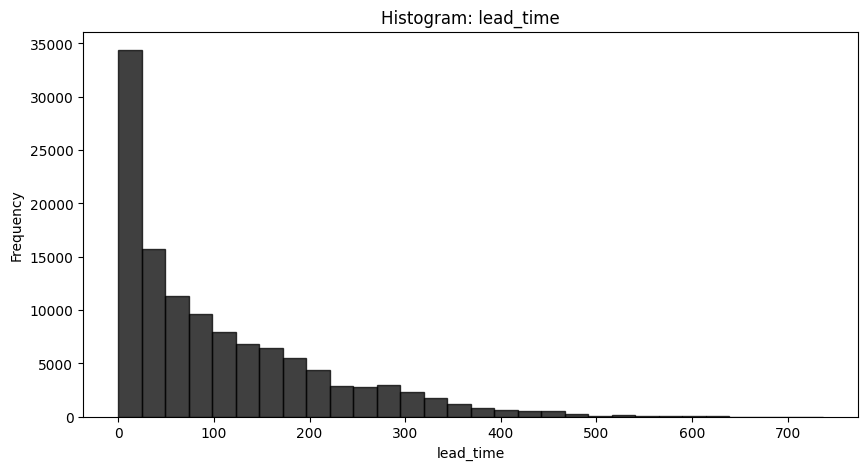

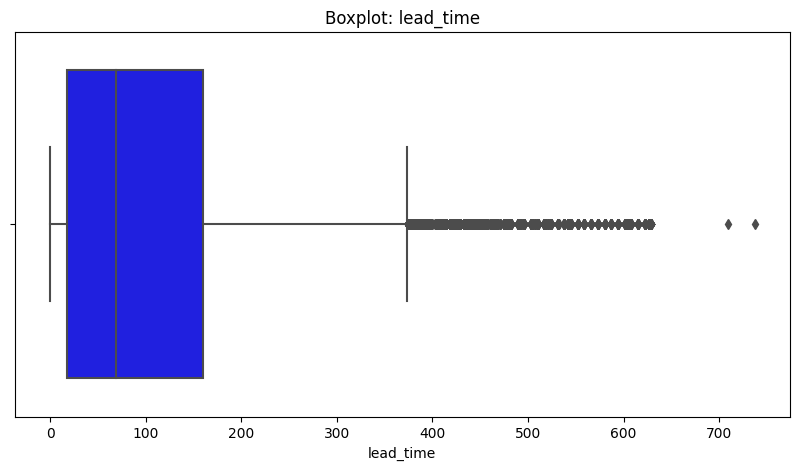

The min value is 0
The median value is 69.0
The mean value is 104.07053711750024
The max value is 737


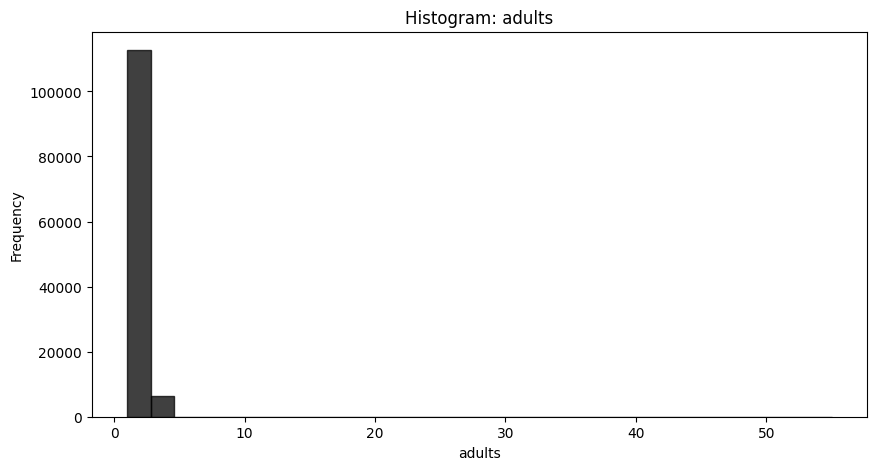

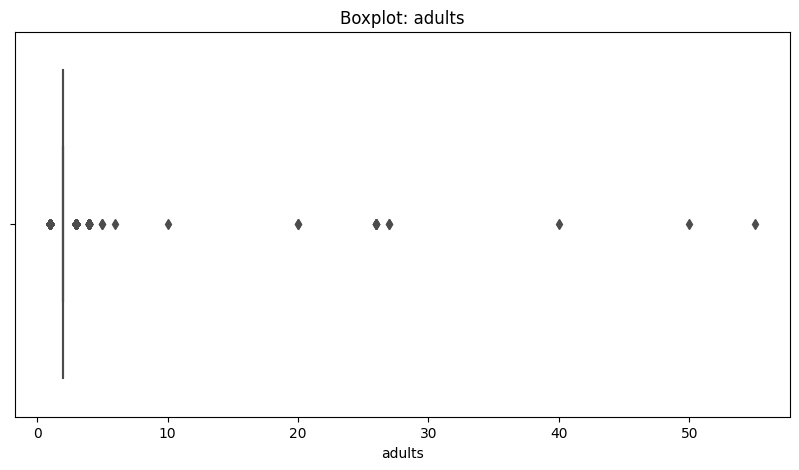

The min value is 1
The median value is 2.0
The mean value is 1.8626908821972148
The max value is 55


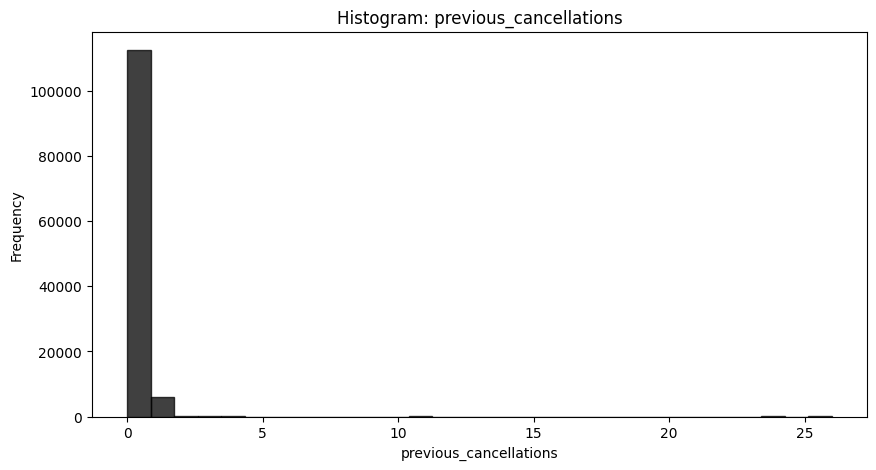

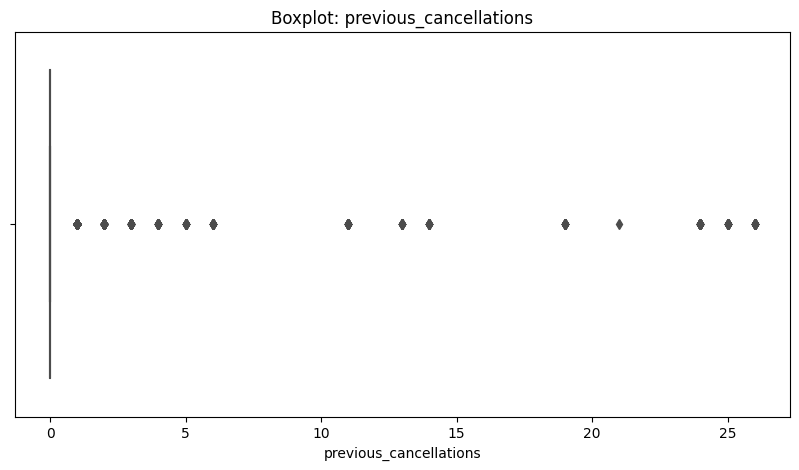

The min value is 0
The median value is 0.0
The mean value is 0.08733727213897316
The max value is 26


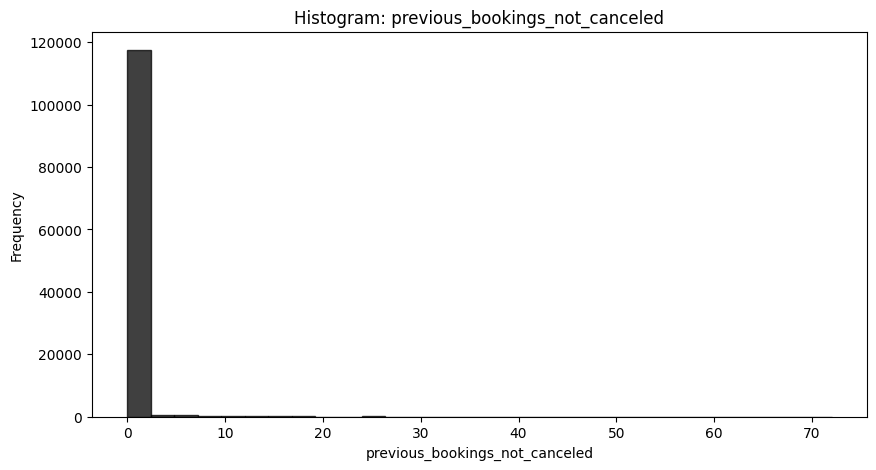

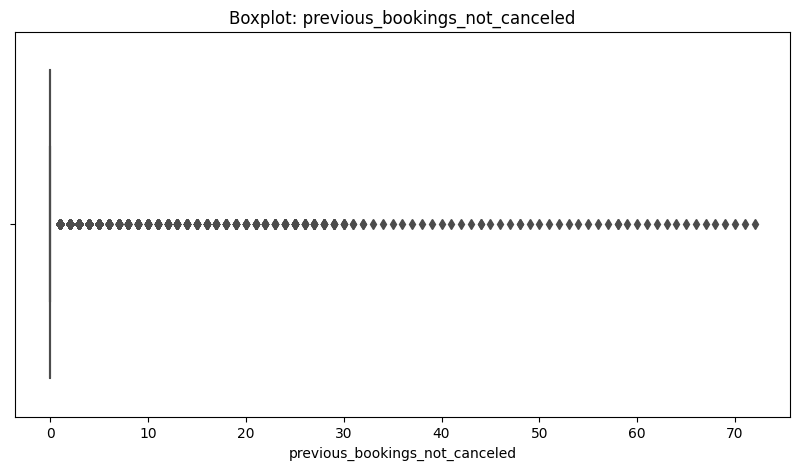

The min value is 0
The median value is 0.0
The mean value is 0.13734273492062157
The max value is 72


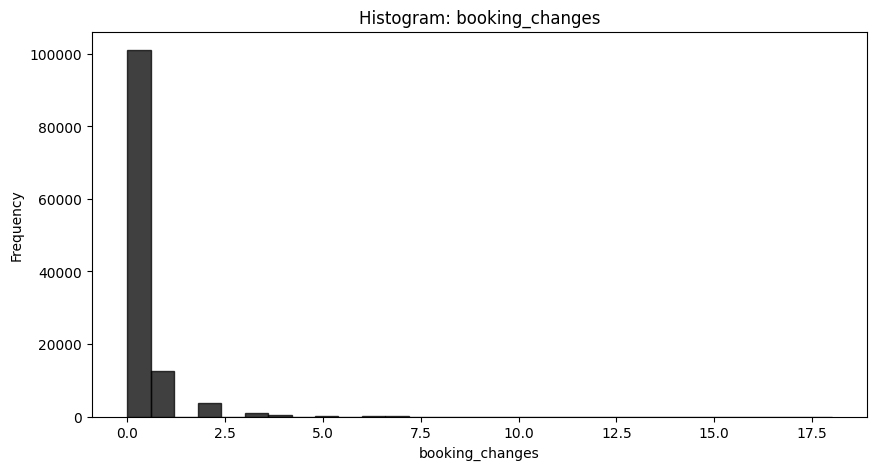

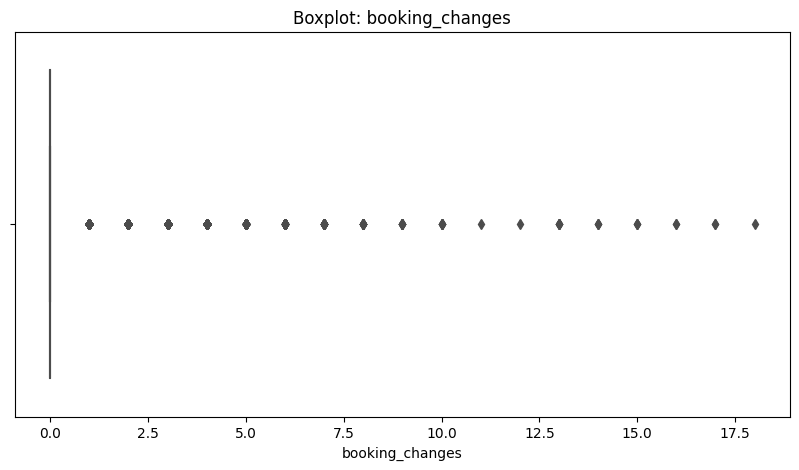

The min value is 0
The median value is 0.0
The mean value is 0.21852807449553313
The max value is 18


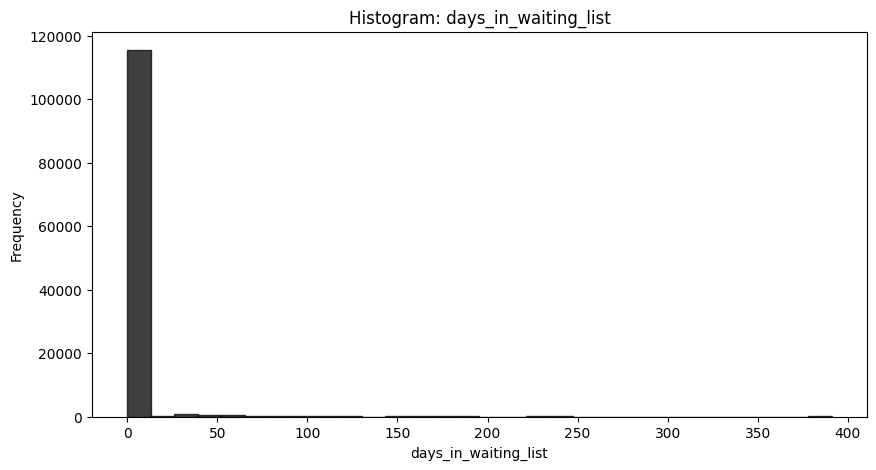

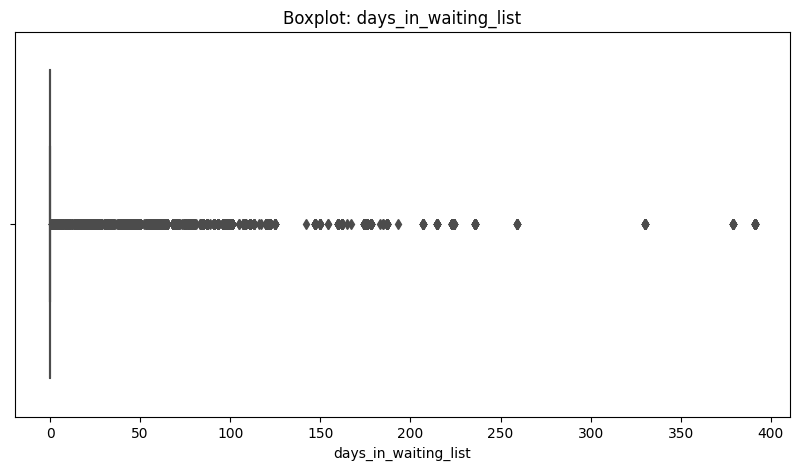

The min value is 0
The median value is 0.0
The mean value is 2.325564977686638
The max value is 391


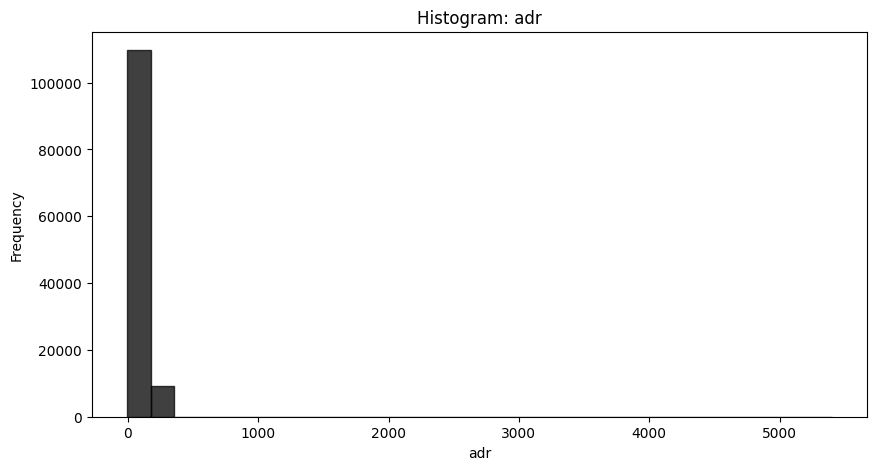

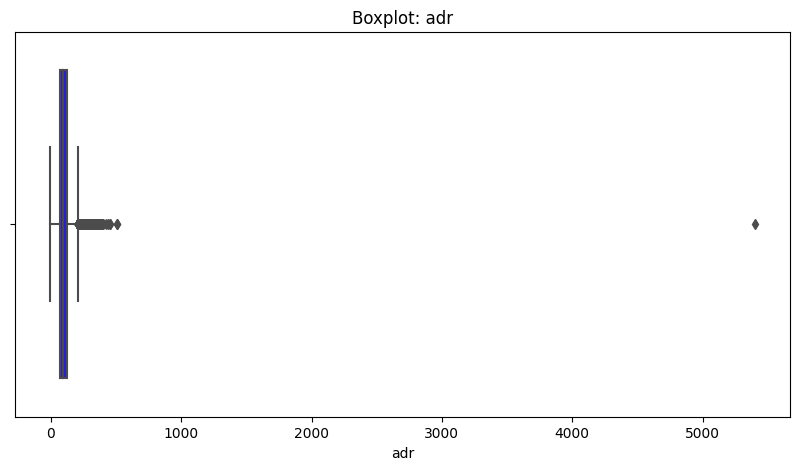

The min value is -6.38
The median value is 95.0
The mean value is 102.00807584021784
The max value is 5400.0


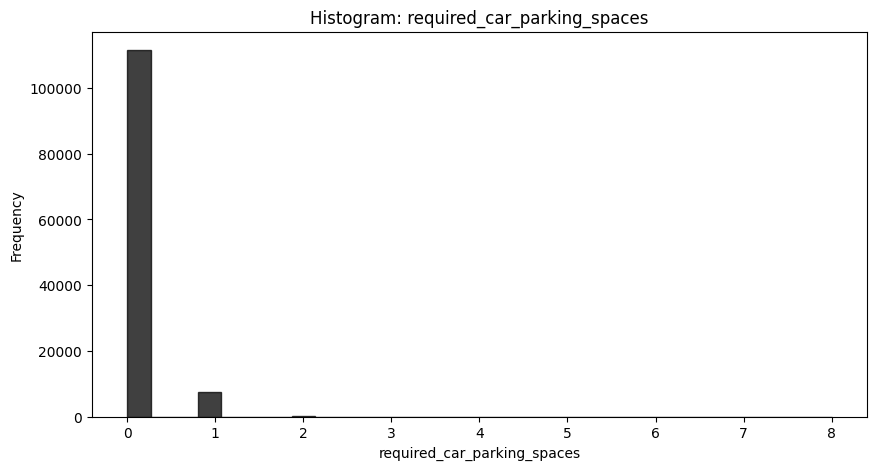

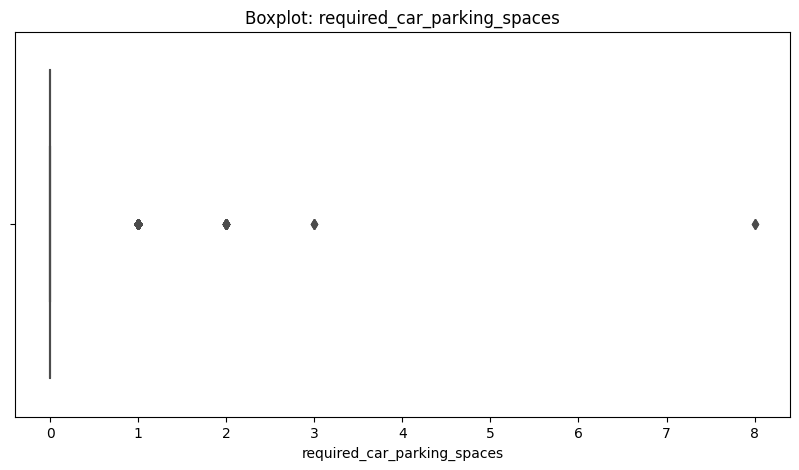

The min value is 0
The median value is 0.0
The mean value is 0.06265390336759478
The max value is 8


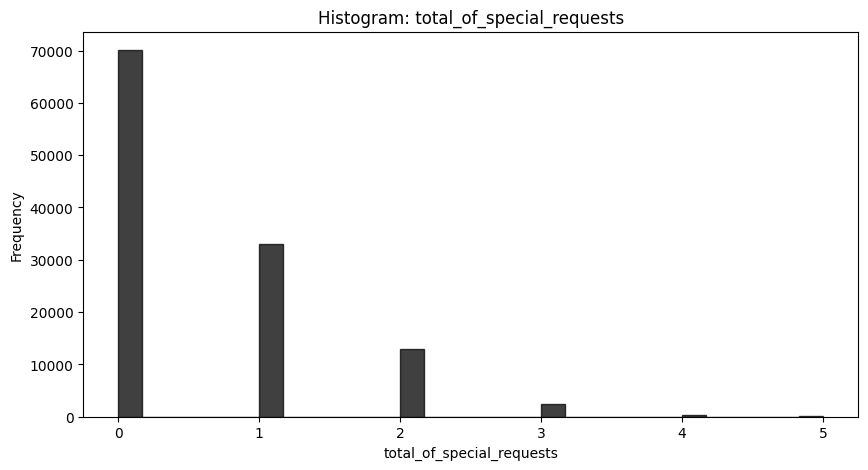

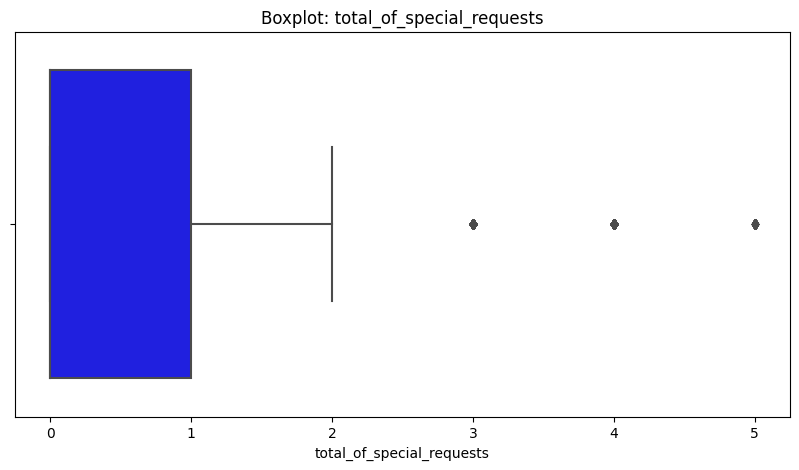

The min value is 0
The median value is 0.0
The mean value is 0.5706421709934699
The max value is 5


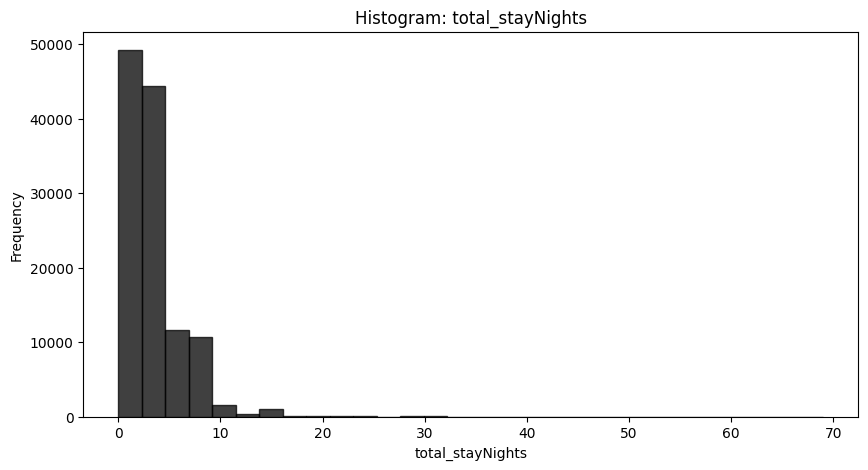

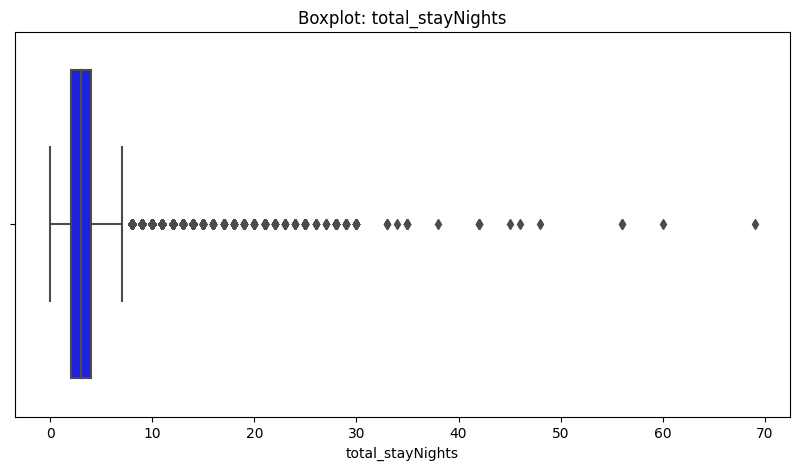

The min value is 0
The median value is 3.0
The mean value is 3.42599611722289
The max value is 69


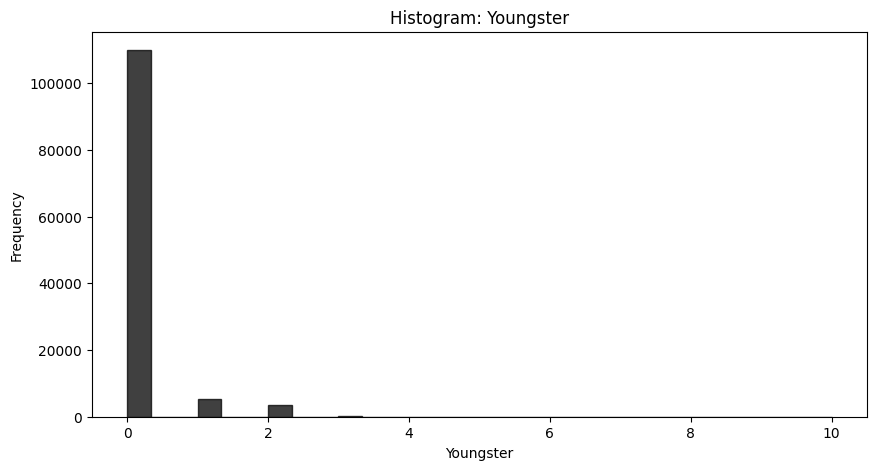

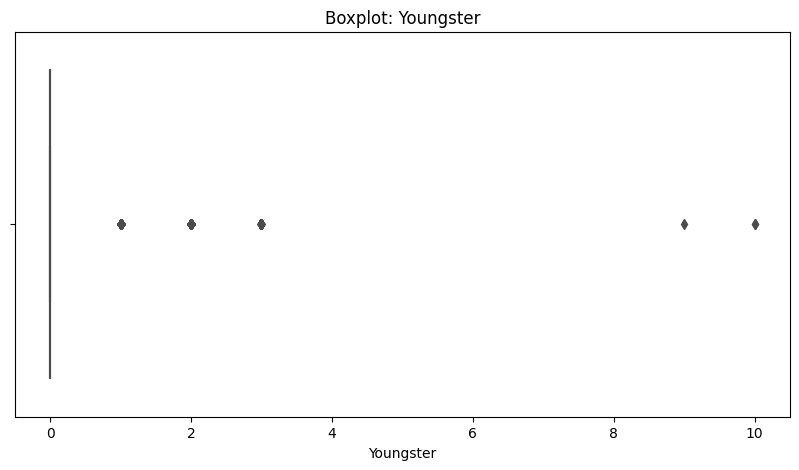

The min value is 0.0
The median value is 0.0
The mean value is 0.108381587904561
The max value is 10.0


In [ ]:
# Create a loop to check histogram for all numeric features
for features in numeric_Var_list_Outliers:
# Histogram
  plt.figure(figsize=(10, 5))
  plt.hist(df1[features], bins=30, alpha=0.75, color='black', edgecolor='black')
  plt.xlabel(features)  # Change the x label according to the current feature
  plt.ylabel('Frequency')
  plt.title(f'Histogram: {features}')  # Add title according to the current feature
  plt.show()

# Boxplot
  plt.figure(figsize=(10, 5))
  sns.boxplot(x=df1[features], color='blue')
  plt.title(f'Boxplot: {features}') 
  plt.xlabel(features)
  plt.show()

# Calculate the min, median, mean, max for each numeric feature
  min_value = df1[features].min()
  max_value = df1[features].max()
  median_value = df1[features].median()
  mean_value = df1[features].mean()
  print('The min value is ' + str(min_value))
  print('The median value is ' + str(median_value))
  print('The mean value is ' + str(mean_value))
  print('The max value is ' + str(max_value))


We determine the 2 right-most points in lead_time that are further from the rest are outliers. 

3 outliers in days_in_waiting_list

1 outliers in adr

In [ ]:
# Drop 2 max values from lead_time as outliers
max_indices = df1.nlargest(2, 'lead_time').index

# Drop the rows with those indices
df1 = df1.drop(max_indices)

# Reset the index if needed
df1.reset_index(drop=True, inplace=True)

In [ ]:
# Drop 3 max values from days_in_waiting_list as outliers
max_indices2 = df1.nlargest(3, 'days_in_waiting_list').index

# Drop the rows with those indices
df1 = df1.drop(max_indices2)

# Reset the index if needed
df1.reset_index(drop=True, inplace=True)

In [ ]:
# Drop the max values from adr as outliers
max_indices3 = df1.nlargest(1, 'adr').index

# Drop the rows with those indices
df1 = df1.drop(max_indices3)

# Reset the index if needed
df1.reset_index(drop=True, inplace=True)

In [ ]:
df1.shape[0]
# we see that there are now 118981 rows compare to 118987 rows originally

118981

After some initial visual inspection throught the plot above, we can see that there is no outliers in the following **3** numeric features: 
**Youngster, total_of_special_requests, required_car_parking_spaces**

There is negative value in adr - Average Daily Rate


# **Feature Engineering**

Among the 12 categorical variables, we use label encoding to 'reservation_status_date' and 'arrival_date_month' since they are ordinal variables, and hash encoding/One-hot encoding to the rest. 
Since 'country' has a really high cardinality - 178 values, we decide to drop this feature.

To preserve the dataset, we create a copy for our original dataset 'df' as 'df1' to do feature engineering

In [ ]:
# 13 categorical features in total
# But only 12 in our list since "is_repeated_guest" are already encoded
Categorical_Var_list

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [ ]:
# Check the value in these 12 categorical variables
for i in Categorical_Var_list:
  print(i)
  print(df1[i].value_counts())
  print('-----------------------')


hotel
City Hotel      78936
Resort Hotel    40045
Name: hotel, dtype: int64
-----------------------
arrival_date_month
August       13829
July         12610
May          11764
October      11128
April        11057
June         10917
September    10489
March         9750
February      8033
November      6765
December      6736
January       5903
Name: arrival_date_month, dtype: int64
-----------------------
meal
BB    92015
HB    14453
SC    11715
FB      798
Name: meal, dtype: int64
-----------------------
country
PRT    48435
GBR    12104
FRA    10376
ESP     8546
DEU     7271
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: country, Length: 178, dtype: int64
-----------------------
market_segment
Online TA        56221
Offline TA/TO    24178
Groups           19788
Direct           12551
Corporate         5282
Complementary      724
Aviation           235
Undefined            2
Name: market_segment, dtype: int64
-----------------------
distribution_c

For variables with low cardinalities, we apply one-hot encoding
The following 6 variables are: hotel, meal, reservation_status, customer_type, deposit_type, distribution_channel

For variables with high cardinalities, we apply feature hashing accrodingly

In [ ]:
# Set to display all rows
pd.set_option('display.max_rows', None)

df['country'].value_counts()
#df['country'].nunique()

PRT        48440
GBR        12105
FRA        10376
ESP         8546
DEU         7271
ITA         3752
IRL         3370
BEL         2326
BRA         2212
NLD         2094
USA         2085
CHE         1717
CN          1279
AUT         1260
SWE         1017
CHN          998
POL          915
ISR          668
RUS          626
NOR          606
ROU          497
unknown      478
FIN          444
DNK          430
AUS          426
AGO          362
LUX          285
MAR          256
TUR          247
HUN          228
ARG          213
JPN          197
CZE          171
IND          150
KOR          132
GRC          128
DZA          103
SRB          101
HRV          100
MEX           84
EST           83
IRN           82
LTU           81
ZAF           79
BGR           75
NZL           74
COL           71
UKR           68
MOZ           67
SVK           65
CHL           64
THA           58
ISL           57
SVN           56
LVA           55
CYP           51
TWN           51
ARE           50
SAU           

In [ ]:
# Replace "CN" into "CHN" which is a valid ISO 3166-1 alpha-3 country codes. 
df['country'] = df['country'].replace('CN', 'CHN')

We decided to hash the above variable using ISO country mapping

In [ ]:
df['market_segment'].value_counts()

Online TA        56221
Offline TA/TO    24179
Groups           19791
Direct           12553
Corporate         5282
Complementary      724
Aviation           235
Undefined            2
Name: market_segment, dtype: int64

In [ ]:
df1['reserved_room_type'].value_counts() # 11 categories

A    85859
D    19178
E     6517
F     2892
G     2091
C      930
B      907
H      601
L        6
Name: reserved_room_type, dtype: int64

In [ ]:
# Replace "L" with the mode category "A" to avoid noise due to that single data point
mode_category2 = df1['reserved_room_type'].mode().iloc[0]
df1['reserved_room_type'].replace('L', mode_category2, inplace=True)
df1['reserved_room_type'].value_counts() # 10 categories now 

A    85865
D    19178
E     6517
F     2892
G     2091
C      930
B      907
H      601
Name: reserved_room_type, dtype: int64

In [ ]:
df1['assigned_room_type'].value_counts() # 11 categories

A    73979
D    25306
E     7797
F     3751
G     2548
C     2369
B     1972
H      712
I      359
K      187
L        1
Name: assigned_room_type, dtype: int64

In [ ]:
# Replace "L" with the mode category "A" to avoid noise due to that single data point
mode_category = df1['assigned_room_type'].mode().iloc[0]
df1['assigned_room_type'].replace('L', mode_category, inplace=True)
df1['assigned_room_type'].value_counts() # 10 categories now 

A    73980
D    25306
E     7797
F     3751
G     2548
C     2369
B     1972
H      712
I      359
K      187
Name: assigned_room_type, dtype: int64

The above variable could also be used with one-hot encoding

In [ ]:
# Apply label encoding to arrival_date_month and reservation_status_date
df1['reservation_status_date']=LabelEncoder().fit_transform(df1['reservation_status_date'])
df1['arrival_date_month']=LabelEncoder().fit_transform(df1['arrival_date_month'])

In [ ]:
#Intall pycountry-convert package to Apply feature hashing with ISO country mapping to variable "country"
!pip install pycountry-convert
import pycountry_convert as pc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 96.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.2/228.2 kB 24.4 MB/s eta 0:00:00
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=09b6b51c4784c214e41ad4957f0aad7d5340967525032f0f0d19fc3e12d8fc3c
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built pycountry


In [ ]:
# Apply feature hashing with ISO country mapping to variable "country"

# Function to convert ISO country code to continent code
def country_to_continent(country_code):
    try:
        # Get the 2-letter country code (alpha_2) from the 3-letter country code (alpha_3)
        country_alpha2 = pc.country_alpha3_to_country_alpha2(country_code)

        # Convert the 2-letter country code to the continent code
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)

        return continent_code
    except KeyError:
        # If the country code is not found, return 'Unknown'
        return 'Unknown'

# Apply the mapping function to the 'country' column to create a new 'continent' column
df1['continent'] = df1['country'].apply(country_to_continent)

# Display the new 'continent' column
print(df1['continent'].value_counts())


EU         107473
AS           3176
SA           2694
NA           2261
Unknown      1764
AF           1107
OC            506
Name: continent, dtype: int64


In [ ]:
# Remove "country" from the dataset since it is now replaced by "continent"
df1 = df1.drop(columns=['country'])

In [ ]:
# Drop "reservation_status" which is highly correlated to the target variable
df1 = df1.drop(columns=['reservation_status'])

In [ ]:
# Apply one-hot encoding to "continent"
df1 = pd.get_dummies(df1, columns= ['continent'] )

In [ ]:
# Apply the rest of the 9 categorical features with one hot encoding
Categorical_Var_list_hot = Categorical_Var_list.copy()
Categorical_Var_list_hot.remove('reservation_status_date')
Categorical_Var_list_hot.remove('arrival_date_month')
Categorical_Var_list_hot.remove('country')
Categorical_Var_list_hot.remove('reservation_status')

# Apply one-hot Encoding
df1 = pd.get_dummies(df1, columns=Categorical_Var_list_hot )

In [ ]:
len(df1.columns) # total number of features is 69

69

### **Apply Standard Scaler to numeric variables in the data set**

In [ ]:
from sklearn.preprocessing import StandardScaler
df1[numeric_Var_list] = StandardScaler().fit_transform(df1[numeric_Var_list])

We will use Variance Inflation Factor (VIF) later to further investigate colinearity and improve our method of incorporating features into our model. 

# **Model Building**

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [ ]:
X = df1.drop(columns = 'is_canceled')
y = df1['is_canceled']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


**We need to decide what's the best number of features in the model (K value).**

**We will select the best value of number of features based on which one gives the best AUC value**

**We will use random forest model to find out which number of features gives the highest AUC value**


In [ ]:
from sklearn.metrics import roc_auc_score


In [ ]:
auc_list = []
k_values = []
selected_features = []

In [ ]:
for nfeatures in range(10, 31):

  k_values.append(nfeatures)

  #apply selectKBest
  selector = SelectKBest(score_func= f_classif, k = nfeatures)
  X_train_clean = selector.fit_transform(X_train, y_train)
  X_test_clean = selector.transform(X_test)

  # fit into the RandomForestModel to find out the AUC score
  rfc = RandomForestClassifier()
  rfc.fit(X_train_clean, y_train)
  y_pred_proba_rfc = rfc.predict_proba(X_test_clean)[:, 1]  # Get predicted probabilities for class 1
  auc_rfc = roc_auc_score(y_test, y_pred_proba_rfc)  # Calculate AUC-ROC score
  auc_list.append(auc_rfc)

   # Get the selected features for this k value
  selected_feature_names = list(X_train.columns[selector.get_support()])
  selected_features.append(selected_feature_names)




In [ ]:
max_auc_index = auc_list.index(max(auc_list))

# Get the k value and feature names for the maximum AUC
best_k = k_values[max_auc_index]
best_features = selected_features[max_auc_index]

print(f"Best k value: {best_k}")
print(f"Selected features for the best k value: {best_features}")

Best k value: 29
Selected features for the best k value: ['lead_time', 'adults', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status_date', 'continent_Unknown', 'hotel_City Hotel', 'hotel_Resort Hotel', 'market_segment_Corporate', 'market_segment_Direct', 'market_segment_Groups', 'distribution_channel_Corporate', 'distribution_channel_Direct', 'distribution_channel_TA/TO', 'reserved_room_type_A', 'reserved_room_type_D', 'assigned_room_type_A', 'assigned_room_type_C', 'assigned_room_type_D', 'assigned_room_type_E', 'deposit_type_No Deposit', 'deposit_type_Non Refund', 'customer_type_Transient', 'customer_type_Transient-Party']


In [ ]:
# Set the number of features to 29
selector = SelectKBest(score_func= f_classif, k = 29)
X_train_clean = selector.fit_transform(X_train, y_train)
X_test_clean = selector.transform(X_test)

### **Logistic Regression**

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_clean, y_train)

y_pred_lr = lr.predict(X_test_clean)
y_pred_proba_lr = lr.predict_proba(X_test_clean)[:, 1]  # Get predicted probabilities for class 1
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)  # Calculate AUC-ROC score
conf_lr = confusion_matrix(y_test, y_pred_lr)

print(f"Confusion Matrix : \n{conf_lr}")
print("AUC is " + str(auc_lr))


Confusion Matrix : 
[[21217  1264]
 [ 6395  6819]]
AUC is 0.8421488352066328


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### **Decision Tree**

In [ ]:
decTree = DecisionTreeClassifier()
decTree.fit(X_train_clean, y_train)

y_pred_decT = decTree.predict(X_test_clean)

y_pred_proba_decT = decTree.predict_proba(X_test_clean)[:, 1]  # Get predicted probabilities for class 1
auc_decT = roc_auc_score(y_test, y_pred_proba_decT)  # Calculate AUC-ROC score
conf_decT = confusion_matrix(y_test, y_pred_decT)

print(f"Confusion Matrix : \n{conf_decT}")
print("AUC is " + str(auc_decT))

Confusion Matrix : 
[[19640  2841]
 [ 2608 10606]]
AUC is 0.8388980181619758


### **Random Forest**

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train_clean, y_train)

y_pred_rfc = rfc.predict(X_test_clean)

y_pred_proba_rfc = rfc.predict_proba(X_test_clean)[:, 1]  # Get predicted probabilities for class 1
auc_rfc = roc_auc_score(y_test, y_pred_proba_rfc)  # Calculate AUC-ROC score
conf_rfc = confusion_matrix(y_test, y_pred_rfc)

print(f"Confusion Matrix : \n{conf_rfc}")
print("AUC is " + str(auc_rfc))

Confusion Matrix : 
[[20688  1793]
 [ 2743 10471]]
AUC is 0.9373597705065065


### **XGB Classifier**

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_clean, y_train)

y_pred_xgb = xgb.predict(X_test_clean)
y_pred_proba_xgb = xgb.predict_proba(X_test_clean)[:, 1]  # Get predicted probabilities for class 1
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)  # Calculate AUC-ROC score
conf_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"Confusion Matrix : \n{conf_xgb}")
print("AUC is " + str(auc_xgb))


Confusion Matrix : 
[[20886  1595]
 [ 3437  9777]]
AUC is 0.9310886272044051


## **Apply 3 fold cross valiation based on Year (2015-2017)**


In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import parallel_backend
from joblib import delayed, Parallel

def cross_validation(model, X, y, n_splits, year_values):
    kf = KFold(n_splits=n_splits)

    auc_scores = []
    precision_scores = []
    recall_scores = []

    for year in year_values:
        year_indices = X['arrival_date_year'] == year
        train_indices = ~year_indices
        test_indices = year_indices

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Apply Selector
        selector = SelectKBest(score_func= f_classif, k = 29)
        X_train_clean = selector.fit_transform(X_train, y_train)
        X_test_clean = selector.transform(X_test)


        # adjustadjust to avoid warning while running balanced random forest (But doesn't seem to change much hhh)
        with parallel_backend('loky'):
            model.fit(X_train_clean, y_train)
            y_pred_proba = model.predict_proba(X_test_clean)[:, 1]
            y_pred = model.predict(X_test_clean)

        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        auc_scores.append(auc)
        precision_scores.append(precision)
        recall_scores.append(recall)

    return sum(auc_scores) / n_splits, sum(precision_scores) / n_splits, sum(recall_scores) / n_splits, y_pred, y_test, y_pred_proba


In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import parallel_backend
from joblib import delayed, Parallel
import pandas as pd

def cross_validation2(model, X, y, n_splits, year_values):
    kf = KFold(n_splits=n_splits)

    auc_scores = []
    precision_scores = []
    recall_scores = []

    actual_values = {}
    predicted_values = {}

    for year in year_values:
        year_indices = X['arrival_date_year'] == year
        train_indices = ~year_indices
        test_indices = year_indices

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Apply Selector
        selector = SelectKBest(score_func=f_classif, k=29)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Combine the selected features with the one-hot encoded continent features
        one_hot_continent_cols = ['continent_AF', 'continent_AS', 'continent_EU', 'continent_NA', 'continent_OC', 'continent_SA', 'continent_Unknown']
        X_train_clean = pd.concat([X_train.iloc[:, selector.get_support(indices=True)], X_train.loc[:, one_hot_continent_cols]], axis=1)
        X_test_clean = pd.concat([X_test.iloc[:, selector.get_support(indices=True)], X_test.loc[:, one_hot_continent_cols]], axis=1)

        # adjust to avoid warning while running balanced random forest (But doesn't seem to change much hhh)
        with parallel_backend('loky'):
            model.fit(X_train_clean, y_train)
            y_pred_proba = model.predict_proba(X_test_clean)[:, 1]
            y_pred = model.predict(X_test_clean)

        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        auc_scores.append(auc)
        precision_scores.append(precision)
        recall_scores.append(recall)

        # Reverse one-hot encoding to get the original continent values
        continent_col = X_test_clean.filter(like="continent_").idxmax(axis=1).str.replace("continent_", "")

        # Store actual and predicted values for each continent
        for continent in continent_col.unique():
            continent_indices = continent_col == continent
            y_actual_continent = y_test[continent_indices]
            y_pred_continent = y_pred[continent_indices]

            if continent not in actual_values:
                actual_values[continent] = y_actual_continent
                predicted_values[continent] = y_pred_continent
            else:
                actual_values[continent] = actual_values[continent].append(y_actual_continent)
                predicted_values[continent] = np.concatenate((predicted_values[continent], y_pred_continent))

    return sum(auc_scores) / n_splits, sum(precision_scores) / n_splits, sum(recall_scores) / n_splits, y_pred, y_test, y_pred_proba, actual_values, predicted_values



In [ ]:
# Remove constant features
constant_features = [37, 42]
X = X.drop(X.columns[constant_features], axis=1)

# Since we get an error by using the SelectKBest method due to feature indice 37 and 42

In [ ]:
year_values = [2015, 2016, 2017]

# Random Forest
rfc = RandomForestClassifier()
auc_rfc, pre_rfc, recall_rfc, y_pred_rfc, y_test_rfc, yPredProb_rfc = cross_validation(rfc, X, y, 3, year_values) 
print(f"Random Forest AUC: {auc_rfc}")
print(f"Random Forest Precision: {pre_rfc}")
print(f"Random Forest Recall: {recall_rfc}")

Random Forest AUC: 0.7818878612108415
Random Forest Precision: 0.6538210221463113
Random Forest Recall: 0.6718748362617619


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

year_values = [2015, 2016, 2017]

# Random Forest
rfc = RandomForestClassifier()
auc_rfc, pre_rfc, recall_rfc, y_pred_rfc, y_test_rfc, y_pred_prob_rfc, actual_values, predicted_values = cross_validation2(rfc, X, y, 3, year_values)

print(f"Random Forest AUC: {auc_rfc}")
print(f"Random Forest Precision: {pre_rfc}")
print(f"Random Forest Recall: {recall_rfc}")

# Evaluate the model performance for each continent
for continent, y_actual_continent in actual_values.items():
    y_pred_continent = predicted_values[continent]

    print(f"\nContinent: {continent}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_actual_continent, y_pred_continent))
    print("Classification Report:")
    print(classification_report(y_actual_continent, y_pred_continent))


<ipython-input-112-1edd710d5e78>:63: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-112-1edd710d5e78>:63: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-112-1edd710d5e78>:63: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-112-1edd710d5e78>:63: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_con

Random Forest AUC: 0.7921800298569863
Random Forest Precision: 0.6556199187589927
Random Forest Recall: 0.6784464314796029

Continent: EU
Confusion Matrix:
[[47503 19438]
 [13661 26871]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74     66941
           1       0.58      0.66      0.62     40532

    accuracy                           0.69    107473
   macro avg       0.68      0.69      0.68    107473
weighted avg       0.70      0.69      0.70    107473


Continent: NA
Confusion Matrix:
[[1408  331]
 [ 349  173]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1739
           1       0.34      0.33      0.34       522

    accuracy                           0.70      2261
   macro avg       0.57      0.57      0.57      2261
weighted avg       0.70      0.70      0.70      2261


Continent: Unknown
Confusion Matrix:
[[1185  266]
 [

<ipython-input-112-1edd710d5e78>:63: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-112-1edd710d5e78>:63: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-112-1edd710d5e78>:63: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-112-1edd710d5e78>:63: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_con

In [ ]:
count = np.sum(yPredProb_rfc > 0.9)
print(f"Number of instances with probability > 0.9: {count}")

Number of instances with probability > 0.9: 4127


In [ ]:
4127/40557

0.10175801957738491

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
auc_lr, pre_lr, recall_lr, y_pred_lr, y_test_lr, yPredProb_lr = cross_validation(lr, X, y, 3, year_values) 
print(f"Logistic Regression AUC: {auc_lr}")
print(f"Logistic Regression Precision: {pre_lr}")
print(f"Logistic Regression Recall: {recall_lr}")

Logistic Regression AUC: 0.8478961440005515
Logistic Regression Precision: 0.8254520374367753
Logistic Regression Recall: 0.521823540163524


In [ ]:
# Decision Tree
dtc = DecisionTreeClassifier()
auc_dtc, pre_dtc, recall_dtc, y_pred_dtc, y_test_dtc, yPredProb_dtc = cross_validation(dtc, X, y, 3, year_values) 
print(f"Decision Tree AUC: {auc_dtc}")
print(f"Decision Tree Precision: {pre_dtc}")
print(f"Decision Tree Recall: {recall_dtc}")

Decision Tree AUC: 0.6077513773313846
Decision Tree Precision: 0.5596604667867018
Decision Tree Recall: 0.7026002224376132


In [ ]:
# XGBClassifier
xgb = XGBClassifier()
auc_xgb, pre_xgb, recall_xgb, y_pred_xgb, y_test_xgb, yPredProb_xgb = cross_validation(xgb, X, y, 3, year_values) 
print(f"XGB Classifier AUC: {auc_xgb}")
print(f"XGB Classifier Precision: {pre_xgb}")
print(f"XGB Classifier Recall: {recall_xgb}")

XGB Classifier AUC: 0.7959092814782428
XGB Classifier Precision: 0.5974108527634876
XGB Classifier Recall: 0.7488353686816273


In [ ]:
# Noticed that precision and recall are inversely proportional, there are class imbalanced
# Introduce balanced Random Forest method
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
auc_brf, pre_brf, recall_brf, y_pred_brf, y_test_brf, yPredProb_brf = cross_validation(brf, X, y, 3, year_values) 
print(f"Balanced Random Forest AUC: {auc_brf}")
print(f"Balanced Random Forest Precision: {pre_brf}")
print(f"Balanced Random Forest Recall: {recall_brf}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


Balanced Random Forest AUC: 0.7878836597055551
Balanced Random Forest Precision: 0.642811769650611
Balanced Random Forest Recall: 0.6869440642806984


Random Forest AUC: 0.7790853222510989

Random Forest Precision: 0.6433683597329702

Random Forest Recall: 0.6773910088259575

The difference in AUC scores can be attributed to the change in the method used to split the data for training and testing. When using a fixed 30% test size, the data was randomly split without considering the "arrival_date_year" feature. In this case, the model might have benefited from the random distribution of data, which may not accurately represent the real-world scenario where data is organized by year.

When applying 3-fold cross-validation based on the "arrival_date_year" feature, the data was split in a more structured manner, with each fold representing a specific year. This approach is more realistic, as it considers the potential differences in data distribution across years. Consequently, the model's performance might be slightly lower, but it is a more accurate representation of how well the model will generalize to unseen data organized by year.

In summary, the difference in AUC scores can be explained by the change in data splitting methods. The 3-fold cross-validation based on the "arrival_date_year" feature provides a more accurate estimate of the model's performance on real-world, year-based data.

Despite the lower complexity compared to XGB and Random Forest, LR is the best performance model. 

# **Ensemble learning**

In [ ]:
# Ensembling
def ensemble_predictions(predictions_list, weights=None):
    if weights is None:
        weights = [1] * len(predictions_list)
    else:
        assert len(predictions_list) == len(weights), "Number of weights should match the number of models in the ensemble."

    weighted_sum = np.zeros_like(predictions_list[0])
    for i, preds in enumerate(predictions_list):
        weighted_sum += weights[i] * preds
    ensemble_preds = weighted_sum / sum(weights)
    return ensemble_preds

# Combine the predictions from the 3 models
y_pred_probs = [yPredProb_rfc, yPredProb_lr, yPredProb_xgb]
ensemble_probs = ensemble_predictions(y_pred_probs)

# Thresholding the probabilities to get class labels (you can adjust the threshold)
threshold = 0.5
y_ensemble_preds = (ensemble_probs > threshold).astype(int)

# Calculate ensemble performance
auc_ensemble = roc_auc_score(y_test_lr, ensemble_probs)
precision_ensemble = precision_score(y_test_lr, y_ensemble_preds)
recall_ensemble = recall_score(y_test_lr, y_ensemble_preds)

print(f"Ensemble AUC: {auc_ensemble}")
print(f"Ensemble Precision: {precision_ensemble}")
print(f"Ensemble Recall: {recall_ensemble}")


Ensemble AUC: 0.8307723255502897
Ensemble Precision: 0.999776236294473
Ensemble Recall: 0.2845316181621346


tune the ensemble model now to avoid the low recall high precision model

In [ ]:
from sklearn.metrics import f1_score

# Find the optimal threshold for balancing recall and precision
thresholds = np.linspace(0.1, 1, 100)
f1_scores = []
for threshold in thresholds:
    y_preds_temp = (ensemble_probs > threshold).astype(int)
    f1_scores.append(f1_score(y_test_lr, y_preds_temp))

optimal_threshold = thresholds[np.argmax(f1_scores)]

# Thresholding the probabilities using the optimal threshold
y_ensemble_preds = (ensemble_probs > optimal_threshold).astype(int)

# Calculate ensemble performance using the optimal threshold
auc_ensemble = roc_auc_score(y_test_lr, ensemble_probs)
precision_ensemble = precision_score(y_test_lr, y_ensemble_preds)
recall_ensemble = recall_score(y_test_lr, y_ensemble_preds)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Ensemble AUC: {auc_ensemble}")
print(f"Ensemble Precision: {precision_ensemble}")
print(f"Ensemble Recall: {recall_ensemble}")


Optimal Threshold: 0.1090909090909091
Ensemble AUC: 0.8325628535578045
Ensemble Precision: 0.6425346750067991
Ensemble Recall: 0.7522766350378909


### Use SMOTE to resampling to deal with the class imbalance


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
def cross_validation_smote(model, X, y, n_splits, year_values):
    kf = KFold(n_splits=n_splits)

    auc_scores = []
    precision_scores = []
    recall_scores = []

    for year in year_values:
        year_indices = X['arrival_date_year'] == year
        train_indices = ~year_indices
        test_indices = year_indices

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Apply Selector
        selector = SelectKBest(score_func=f_classif, k=29)
        X_train_clean = selector.fit_transform(X_train, y_train)
        X_test_clean = selector.transform(X_test)

        # Apply SMOTE
        smote = SMOTE()
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_clean, y_train)

        # Fit the model and predict
        with parallel_backend('loky'):
            model.fit(X_train_resampled, y_train_resampled)
            y_pred_proba = model.predict_proba(X_test_clean)[:, 1]
            y_pred = model.predict(X_test_clean)

        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        auc_scores.append(auc)
        precision_scores.append(precision)
        recall_scores.append(recall)

    return sum(auc_scores) / n_splits, sum(precision_scores) / n_splits, sum(recall_scores) / n_splits, y_pred, y_test, y_pred_proba


In [ ]:
def ensemble_predictions(predictions_list, weights=None):
    if weights is None:
        weights = [1] * len(predictions_list)
    else:
        assert len(predictions_list) == len(weights), "Number of weights should match the number of models in the ensemble."

    weighted_sum = np.zeros_like(predictions_list[0])
    for i, preds in enumerate(predictions_list):
        weighted_sum += weights[i] * preds
    ensemble_preds = weighted_sum / sum(weights)
    return ensemble_preds

# Define models
rfc = RandomForestClassifier()
lr = LogisticRegression()
xgb = XGBClassifier()

# Set threshold
threshold = 0.5

year_values = pd.Series([2015, 2016, 2017])

# Run cross-validation with SMOTE for each model
_, _, _, _, y_test_rfc, yPredProb_rfc = cross_validation_smote(rfc, X, y, 3, year_values)
_, _, _, _, y_test_lr, yPredProb_lr = cross_validation_smote(lr, X, y, 3, year_values)
_, _, _, _, y_test_xgb, yPredProb_xgb = cross_validation_smote(xgb, X, y, 3, year_values)


In [ ]:

# Combine the predictions from the 3 models
y_pred_probs = [yPredProb_rfc, yPredProb_lr, yPredProb_xgb]
ensemble_probs = ensemble_predictions(y_pred_probs)

# Thresholding the probabilities to get class labels (you can adjust the threshold)
threshold = 0.5
y_ensemble_preds = (ensemble_probs > threshold).astype(int)

# Assuming all models have the same test set (y_test_lr is used here, but y_test_rfc or y_test_xgb could be used as well)
# Calculate ensemble performance
auc_ensemble = roc_auc_score(y_test_lr, ensemble_probs)
precision_ensemble = precision_score(y_test_lr, y_ensemble_preds)
recall_ensemble = recall_score(y_test_lr, y_ensemble_preds)

print(f"Ensemble AUC: {auc_ensemble}")
print(f"Ensemble Precision: {precision_ensemble}")
print(f"Ensemble Recall: {recall_ensemble}")


Ensemble AUC: 0.8283977780681772
Ensemble Precision: 0.9995726495726496
Ensemble Recall: 0.2979048589441508


### **Analyze by Continent**

In [ ]:
def cross_validation_smote2(model, X, y, n_splits, year_values):
    kf = KFold(n_splits=n_splits)

    auc_scores = []
    precision_scores = []
    recall_scores = []

    actual_values = {}
    predicted_values = {}

    def rename_duplicate_columns(df):
        cols = pd.Series(df.columns)
        for dup in cols[cols.duplicated()].unique(): 
            cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
        df.columns = cols

    for year in year_values:
        year_indices = X['arrival_date_year'] == year
        train_indices = ~year_indices
        test_indices = year_indices

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Apply Selector
        selector = SelectKBest(score_func=f_classif, k=29)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Combine the selected features with the one-hot encoded continent features
        one_hot_continent_cols = ['continent_AF', 'continent_AS', 'continent_EU', 'continent_NA', 'continent_OC', 'continent_SA', 'continent_Unknown']
        X_train_clean = pd.concat([X_train.iloc[:, selector.get_support(indices=True)], X_train.loc[:, one_hot_continent_cols]], axis=1)
        X_test_clean = pd.concat([X_test.iloc[:, selector.get_support(indices=True)], X_test.loc[:, one_hot_continent_cols]], axis=1)

        # Rename duplicate columns
        rename_duplicate_columns(X_train_clean)
        rename_duplicate_columns(X_test_clean)

        # Apply SMOTE
        smote = SMOTE()
        X_train_smote, y_train_smote = smote.fit_resample(X_train_clean, y_train)

        print("X_train_clean columns:", X_train_clean.columns)
        # Train the model and make predictions
        model.fit(X_train_smote, y_train_smote)
        y_pred_proba = model.predict_proba(X_test_clean)[:, 1]
        y_pred = model.predict(X_test_clean)

        # Calculate performance metrics
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        auc_scores.append(auc)
        precision_scores.append(precision)
        recall_scores.append(recall)

        # Reverse one-hot encoding to get the original continent values
        continent_col = X_test_clean.filter(like="continent_").idxmax(axis=1).str.replace("continent_", "")

        # Store actual and predicted values for each continent
        for continent in continent_col.unique():
            continent_indices = continent_col == continent
            y_actual_continent = y_test[continent_indices]
            y_pred_continent = y_pred[continent_indices]

            if continent not in actual_values:
                actual_values[continent] = y_actual_continent
                predicted_values[continent] = y_pred_continent
            else:
                actual_values[continent] = actual_values[continent].append(y_actual_continent)
                predicted_values[continent] = np.concatenate((predicted_values[continent], y_pred_continent))

    return sum(auc_scores) / n_splits, sum(precision_scores) / n_splits, sum(recall_scores) / n_splits, y_pred, y_test, y_pred_proba, actual_values, predicted_values


In [ ]:
# Run cross-validation with SMOTE for each model
_, _, _, _, y_test_rfc, yPredProb_rfc, actual_values_rfc, predicted_values_rfc = cross_validation_smote2(rfc, X, y, 3, year_values)
_, _, _, _, y_test_lr, yPredProb_lr, actual_values_lr, predicted_values_lr = cross_validation_smote2(lr, X, y, 3, year_values)
_, _, _, _, y_test_xgb, yPredProb_xgb, actual_values_xgb, predicted_values_xgb = cross_validation_smote2(xgb, X, y, 3, year_values)

# Combine the predictions from the 3 models
y_pred_probs = [yPredProb_rfc, yPredProb_lr, yPredProb_xgb]
ensemble_probs = ensemble_predictions(y_pred_probs)

# Evaluate the ensemble method for each continent
for continent, y_actual_continent in actual_values_rfc.items():
    y_pred_continent_rfc = predicted_values_rfc[continent]
    y_pred_continent_lr = predicted_values_lr[continent]
    y_pred_continent_xgb = predicted_values_xgb[continent]

    y_pred_probs_continent = [y_pred_continent_rfc, y_pred_continent_lr, y_pred_continent_xgb]
    ensemble_probs_continent = ensemble_predictions(y_pred_probs_continent)

    threshold = 0.5
    y_ensemble_preds_continent = (ensemble_probs_continent > threshold).astype(int)

    print(f"\nContinent: {continent}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_actual_continent, y_ensemble_preds_continent))
    print("Classification Report:")
    print


X_train_clean columns: Index(['lead_time', 'adults', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status_date',
       'continent_Unknown', 'hotel_City Hotel', 'hotel_Resort Hotel',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'distribution_channel_Corporate',
       'distribution_channel_Direct', 'distribution_channel_TA/TO',
       'reserved_room_type_A', 'assigned_room_type_A', 'assigned_room_type_D',
       'assigned_room_type_E', 'deposit_type_No Deposit',
       'deposit_type_Non Refund', 'customer_type_Contract',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'continent_AF', 'continent_AS', 'continent_EU', 'continent_NA',
       'continent_OC', 'continent_SA', 'continent_Unknown_1'],
      dtype='object')
X_train_clean columns: I

<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_contine

X_train_clean columns: Index(['lead_time', 'is_repeated_guest', 'previous_cancellations',
       'booking_changes', 'days_in_waiting_list',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date', 'continent_EU', 'hotel_City Hotel',
       'hotel_Resort Hotel', 'meal_FB', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'distribution_channel_Corporate', 'distribution_channel_Direct',
       'distribution_channel_TA/TO', 'reserved_room_type_A',
       'reserved_room_type_D', 'assigned_room_type_A', 'assigned_room_type_B',
       'assigned_room_type_C', 'assigned_room_type_D', 'assigned_room_type_E',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'continent_AF', 'continent_AS', 'continent_EU_1', 'continent_NA',
       'continent_OC', 'continent_SA', 'continent_Unknown'],
      dtype='object')


<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_contine

X_train_clean columns: Index(['lead_time', 'adults', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status_date',
       'continent_Unknown', 'hotel_City Hotel', 'hotel_Resort Hotel',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'distribution_channel_Corporate',
       'distribution_channel_Direct', 'distribution_channel_TA/TO',
       'reserved_room_type_A', 'assigned_room_type_A', 'assigned_room_type_D',
       'assigned_room_type_E', 'deposit_type_No Deposit',
       'deposit_type_Non Refund', 'customer_type_Contract',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'continent_AF', 'continent_AS', 'continent_EU', 'continent_NA',
       'continent_OC', 'continent_SA', 'continent_Unknown_1'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


X_train_clean columns: Index(['lead_time', 'adults', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date', 'continent_EU', 'hotel_City Hotel',
       'hotel_Resort Hotel', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'distribution_channel_Corporate', 'distribution_channel_Direct',
       'distribution_channel_TA/TO', 'reserved_room_type_A',
       'reserved_room_type_D', 'assigned_room_type_A', 'assigned_room_type_C',
       'assigned_room_type_D', 'assigned_room_type_E', 'assigned_room_type_F',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'continent_AF', 'continent_AS', 'continent_EU_1', 'continent_NA',
       'continent_OC', 'continent_SA', 'continent_Unknown'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actua

X_train_clean columns: Index(['lead_time', 'is_repeated_guest', 'previous_cancellations',
       'booking_changes', 'days_in_waiting_list',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date', 'continent_EU', 'hotel_City Hotel',
       'hotel_Resort Hotel', 'meal_FB', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'distribution_channel_Corporate', 'distribution_channel_Direct',
       'distribution_channel_TA/TO', 'reserved_room_type_A',
       'reserved_room_type_D', 'assigned_room_type_A', 'assigned_room_type_B',
       'assigned_room_type_C', 'assigned_room_type_D', 'assigned_room_type_E',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'continent_AF', 'continent_AS', 'continent_EU_1', 'continent_NA',
       'continent_OC', 'continent_SA', 'continent_Unknown'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actua

X_train_clean columns: Index(['lead_time', 'adults', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status_date',
       'continent_Unknown', 'hotel_City Hotel', 'hotel_Resort Hotel',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'distribution_channel_Corporate',
       'distribution_channel_Direct', 'distribution_channel_TA/TO',
       'reserved_room_type_A', 'assigned_room_type_A', 'assigned_room_type_D',
       'assigned_room_type_E', 'deposit_type_No Deposit',
       'deposit_type_Non Refund', 'customer_type_Contract',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'continent_AF', 'continent_AS', 'continent_EU', 'continent_NA',
       'continent_OC', 'continent_SA', 'continent_Unknown_1'],
      dtype='object')
X_train_clean columns: I

<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_contine

X_train_clean columns: Index(['lead_time', 'is_repeated_guest', 'previous_cancellations',
       'booking_changes', 'days_in_waiting_list',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date', 'continent_EU', 'hotel_City Hotel',
       'hotel_Resort Hotel', 'meal_FB', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'distribution_channel_Corporate', 'distribution_channel_Direct',
       'distribution_channel_TA/TO', 'reserved_room_type_A',
       'reserved_room_type_D', 'assigned_room_type_A', 'assigned_room_type_B',
       'assigned_room_type_C', 'assigned_room_type_D', 'assigned_room_type_E',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'continent_AF', 'continent_AS', 'continent_EU_1', 'continent_NA',
       'continent_OC', 'continent_SA', 'continent_Unknown'],
      dtype='object')

Continent: EU
Confusio

<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_continent)
<ipython-input-84-e2ec63156691>:71: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_values[continent] = actual_values[continent].append(y_actual_contine

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

continents = ['EU', 'NA', 'AS', 'SA', 'OC', 'AF']
confusion_matrices = {
    'EU': [[45560, 21381], [12610, 27922]],
    'NA': [[1391, 348], [341, 181]],
    'AS': [[1440, 532], [514, 690]],
    'SA': [[1318, 425], [471, 480]],
    'OC': [[296, 96], [75, 39]],
    'AF': [[488, 144], [219, 256]]
}

for continent in continents:
    cm = confusion_matrices[continent]
    precision = cm[1][1] / (cm[1][1] + cm[0][1])
    recall = cm[1][1] / (cm[1][1] + cm[1][0])
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"Continent: {continent}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}\n")


Continent: EU
Precision: 0.57
Recall: 0.69
F1-score: 0.62

Continent: NA
Precision: 0.34
Recall: 0.35
F1-score: 0.34

Continent: AS
Precision: 0.56
Recall: 0.57
F1-score: 0.57

Continent: SA
Precision: 0.53
Recall: 0.50
F1-score: 0.52

Continent: OC
Precision: 0.29
Recall: 0.34
F1-score: 0.31

Continent: AF
Precision: 0.64
Recall: 0.54
F1-score: 0.59



# **Plot Countries**

In [ ]:
pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 88.9 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd

In [ ]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

<ipython-input-86-088d7dc697fb>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<Axes: >

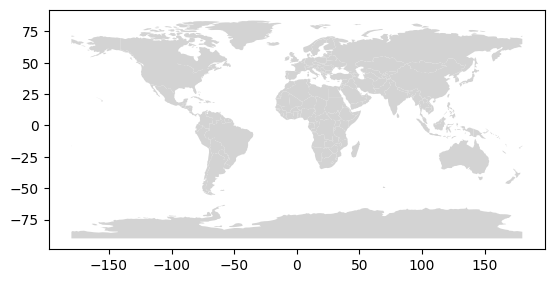

In [ ]:
countries.plot(color="lightgrey")

In [ ]:
cancellation_count = df.groupby('country')['is_canceled'].sum().reset_index()
cancellation_count_order = cancellation_count.sort_values(by='is_canceled', ascending=False).reset_index()

In [ ]:
# Calculate total bookings for each country
total_bookings = df.groupby('country')['is_canceled'].count().reset_index()
total_bookings = total_bookings.rename(columns={'is_canceled': 'total_bookings'})

# Calculate cancellation count for each country
cancellation_count = df[df['is_canceled'] == 1].groupby('country')['is_canceled'].count().reset_index()

# Merge the DataFrames
cancellation_data = pd.merge(cancellation_count, total_bookings, on='country')

# Filter out countries with total bookings less than 30
cancellation_data = cancellation_data[cancellation_data['total_bookings'] >= 1000]

# Calculate the cancellation rate
cancellation_data['cancellation_rate'] = cancellation_data['is_canceled'] / cancellation_data['total_bookings']

# Sort by cancellation rate in descending order
cancellation_rate_order = cancellation_data.sort_values(by='cancellation_rate', ascending=False).reset_index(drop=True)

print(cancellation_rate_order)


   country  is_canceled  total_bookings  cancellation_rate
0      PRT        27494           48440           0.567589
1      BRA          824            2212           0.372514
2      ITA         1328            3752           0.353945
3      CHN          715            2277           0.314010
4      ESP         2173            8546           0.254271
5      CHE          427            1717           0.248690
6      IRL          830            3370           0.246291
7      USA          497            2085           0.238369
8      SWE          225            1017           0.221239
9      BEL          471            2326           0.202494
10     GBR         2449           12105           0.202313
11     FRA         1928           10376           0.185813
12     NLD          382            2094           0.182426
13     AUT          228            1260           0.180952
14     DEU         1215            7271           0.167102


In [ ]:
import pycountry

def convert_country_code_to_name(code):
    country = pycountry.countries.get(alpha_3=code)
    if country:
        return country.name
    else:
        return "unknown"

In [ ]:

cancellation_rate_order['country_name'] = cancellation_rate_order['country'].apply(convert_country_code_to_name)
cancellation_rate_order_sorted = cancellation_rate_order.sort_values(by='cancellation_rate', ascending=False)
cancellation_rate_order_sorted

# print(cancellation_rate_order_sorted)

,country,is_canceled,total_bookings,cancellation_rate,country_name
0,PRT,27494,48440,0.567589,Portugal
1,BRA,824,2212,0.372514,Brazil
2,ITA,1328,3752,0.353945,Italy
3,CHN,715,2277,0.314010,China
4,ESP,2173,8546,0.254271,Spain
5,CHE,427,1717,0.248690,Switzerland
6,IRL,830,3370,0.246291,Ireland
7,USA,497,2085,0.238369,United States
8,SWE,225,1017,0.221239,Sweden
9,BEL,471,2326,0.202494,Belgium


In [ ]:


cancellation_count['country_name'] = cancellation_count['country'].apply(convert_country_code_to_name)
cancellation_count_sorted = cancellation_count.sort_values(by='is_canceled', ascending=False)

cancellation_count_sorted


,country,is_canceled,country_name
96,PRT,27494,Portugal
40,GBR,2449,United Kingdom
32,ESP,2173,Spain
37,FRA,1928,France
59,ITA,1328,Italy
26,DEU,1215,Germany
55,IRL,830,Ireland
16,BRA,824,Brazil
19,CHN,715,China
118,USA,497,United States


<ipython-input-94-abc4ecd01ea2>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


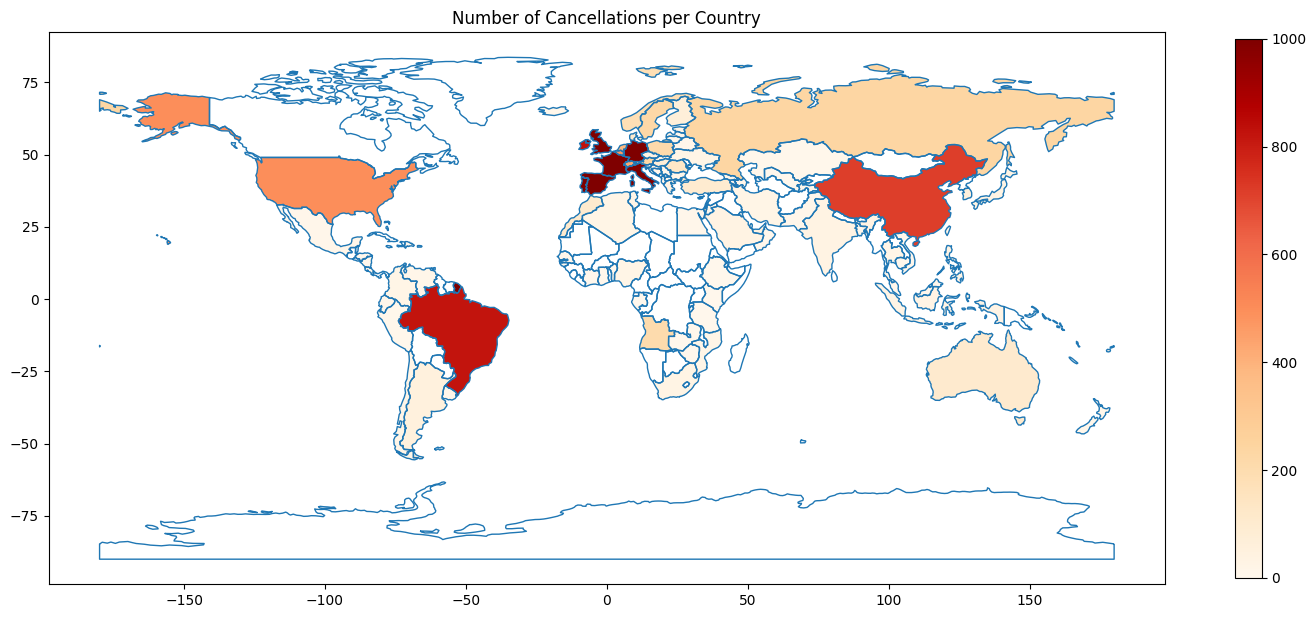

In [ ]:
import matplotlib.colors as colors

# Load the country shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge cancellation_count with the geopandas world dataframe
world_cancellations = world.merge(cancellation_count, left_on='iso_a3', right_on='country')

# Plot the number of cancellations per country with a custom colorbar range
fig, ax = plt.subplots(figsize=(18, 14))
world.boundary.plot(ax=ax, linewidth=1)

# Set the maximum value of the colorbar to 1000 and clip values above it
max_value = 1000
norm = colors.Normalize(vmin=0, vmax=max_value, clip=True)

# Set colorbar height by adjusting the 'shrink' parameter
legend_kwds = {'shrink': 0.5}

world_cancellations.plot(column='is_canceled', cmap='OrRd', norm=norm, legend=True, ax=ax, legend_kwds=legend_kwds)
ax.set_title('Number of Cancellations per Country')
plt.show()


<ipython-input-98-aa6adb0c2ff3>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


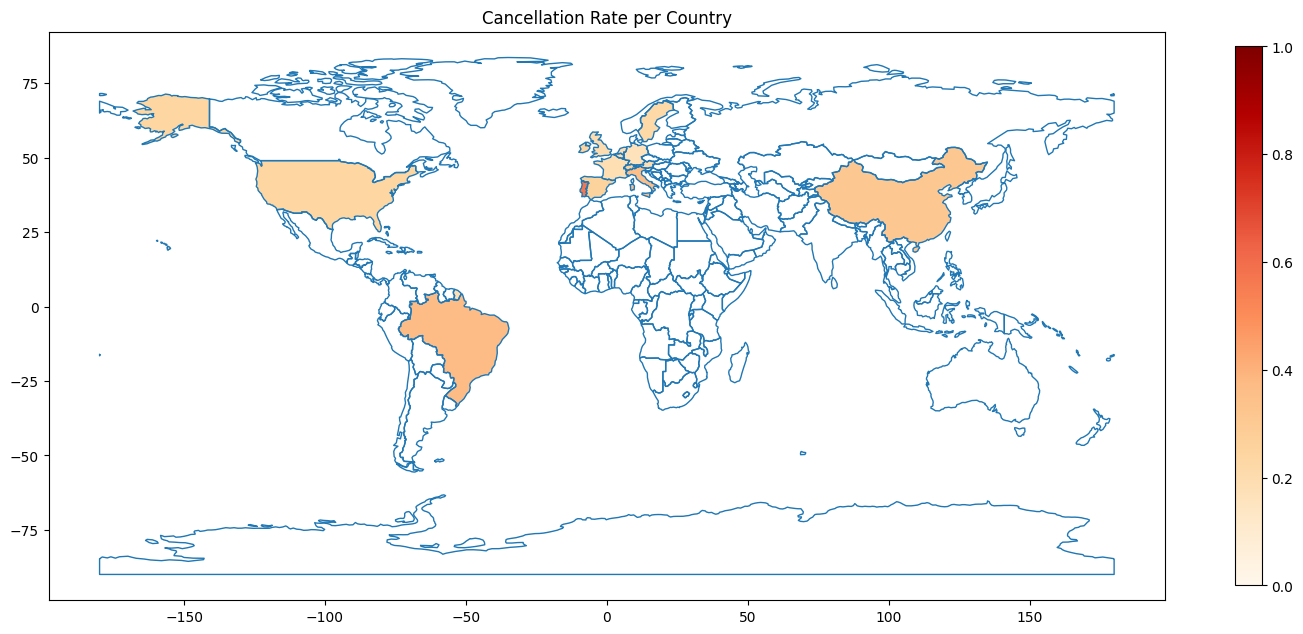

In [ ]:
import matplotlib.colors as colors

# Load the country shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge cancellation_count with the geopandas world dataframe
world_cancellations = world.merge(cancellation_rate_order, left_on='iso_a3', right_on='country')

# Plot the number of cancellations per country with a custom colorbar range
fig, ax = plt.subplots(figsize=(18, 14))
world.boundary.plot(ax=ax, linewidth=1)

# Set the maximum value of the colorbar to 1000 and clip values above it
max_value = 1
norm = colors.Normalize(vmin=0, vmax=max_value, clip=True)

# Set colorbar height by adjusting the 'shrink' parameter
legend_kwds = {'shrink': 0.5}

world_cancellations.plot(column='cancellation_rate', cmap='OrRd', norm=norm, legend=True, ax=ax, legend_kwds=legend_kwds)
ax.set_title('Cancellation Rate per Country')
plt.show()


array([1, 0, 0, ..., 0, 0, 0])